### Description



Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successfu

### Problem:
The Description mention that the goal of this compition is to filter out people whether they would pay the loan transaction on time or not,
giving that you have very small amount of data for those people (People aren't have historical transaction).

Target variable
1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample.
0 - all other cases

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency 


### Loading the data

In [2]:
app_train = pd.read_csv('application_train.csv')
app_test=pd.read_csv('application_test.csv')

In [3]:
app_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


bureau = pd.read_csv('bureau.csv')
bureau_bal = pd.read_csv('bureau_balance.csv')
pos_cash = pd.read_csv('POS_CASH_balance.csv')
cc_bal = pd.read_csv('credit_card_balance.csv')
app_prev = pd.read_csv('previous_application.csv')
instal_pay = pd.read_csv('installments_payments.csv')

### quick view

In [5]:
app_train.shape

(307511, 122)

In [6]:
app_test.shape

(48744, 121)

In [7]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA
* Univariate Analysis
  * 1.1 Inspect for duplicates
  * 1.2 Inspect NaN values
  * 1.3 Inspect for Unreal data and transform it to NaN (if needed)
  * 1.4 Inspect numerical and categorical features for transformations (If needed)
  * 1.5 Inspect Outliers
  * 1.6 Inspect all the features and see whether their is a need to change data types or need to special transformation (e.g. log transformation) or is there an imbalanced data

1.1 Inspecting for duplicates

In [8]:
app_train.duplicated().sum()

0

1.2  Inspecting nan values

In [9]:
app_train.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [10]:
app_test.isnull().sum()

SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_YEAR    6049
Length: 121, dtype: int64

So we can observe that there are a lot of null values

1.3 Inspect for any unreal data and transform it to NaN

In [11]:
for i in app_train:
    if app_train[i].dtype == 'O': # Filter only the categorical variables 
        print(f"{i} contain:", app_train[i].unique())
        print("------------------")

NAME_CONTRACT_TYPE contain: ['Cash loans' 'Revolving loans']
------------------
CODE_GENDER contain: ['M' 'F' 'XNA']
------------------
FLAG_OWN_CAR contain: ['N' 'Y']
------------------
FLAG_OWN_REALTY contain: ['Y' 'N']
------------------
NAME_TYPE_SUITE contain: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
------------------
NAME_INCOME_TYPE contain: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
------------------
NAME_EDUCATION_TYPE contain: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
------------------
NAME_FAMILY_STATUS contain: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
------------------
NAME_HOUSING_TYPE contain: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
------------------
OC

### Findings
I can see in CODE_GENDER and ORGANIZATION_TYPE Columns have 'XNA' Value and due to the reply of one of the compition hosts at this link https://www.kaggle.com/c/home-credit-default-risk/discussion/57248 we will consider the 'XNA' and 'XNP' are NaN values (Check the first reply by 'Martin Kotek')
Also in column NAME_FAMILY_STATUS there's 'Uknown' value which I'll consider also as a NAN

In [12]:
print(app_train[['ORGANIZATION_TYPE','NAME_FAMILY_STATUS', 'CODE_GENDER']].isnull().sum())
print('-'*40)
print(app_test[['ORGANIZATION_TYPE','NAME_FAMILY_STATUS', 'CODE_GENDER']].isnull().sum())

ORGANIZATION_TYPE     0
NAME_FAMILY_STATUS    0
CODE_GENDER           0
dtype: int64
----------------------------------------
ORGANIZATION_TYPE     0
NAME_FAMILY_STATUS    0
CODE_GENDER           0
dtype: int64


In [13]:
users_nan = (app_train.isnull().sum() / app_train.shape[0]) * 100
users_nan[users_nan > 0].sort_values(ascending=False)

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
                              ...    
EXT_SOURCE_2                 0.214626
AMT_GOODS_PRICE              0.090403
AMT_ANNUITY                  0.003902
CNT_FAM_MEMBERS              0.000650
DAYS_LAST_PHONE_CHANGE       0.000325
Length: 67, dtype: float64

In [14]:
app_train.replace({'XNA': np.nan, 'XNP': np.nan, 'Unknown': np.nan}, inplace = True)
app_test.replace({'XNA': np.nan, 'XNP': np.nan, 'Unknown': np.nan}, inplace = True)


In [15]:
print(app_train[['ORGANIZATION_TYPE','NAME_FAMILY_STATUS', 'CODE_GENDER']].isnull().sum())
print('-'*40)
print(app_test[['ORGANIZATION_TYPE','NAME_FAMILY_STATUS', 'CODE_GENDER']].isnull().sum())

ORGANIZATION_TYPE     55374
NAME_FAMILY_STATUS        2
CODE_GENDER               4
dtype: int64
----------------------------------------
ORGANIZATION_TYPE     9274
NAME_FAMILY_STATUS       0
CODE_GENDER              0
dtype: int64


In [16]:
users_nan = (app_train.isnull().sum() / app_train.shape[0]) * 100
users_nan[users_nan > 0].sort_values(ascending=False)

COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
                              ...    
AMT_ANNUITY                  0.003902
CODE_GENDER                  0.001301
CNT_FAM_MEMBERS              0.000650
NAME_FAMILY_STATUS           0.000650
DAYS_LAST_PHONE_CHANGE       0.000325
Length: 70, dtype: float64

### Dropping the columns which contain more than 40% NaN

In [17]:
# Note: I'll use the same filteration "app_train.columns[app_train.isnull().mean()>0.4]"
# in test and train data as I need to drop the same columns even if those columns are more clean in test_data

app_test.drop(app_train.columns[app_train.isnull().mean()>0.4],axis=1, inplace=True)
app_train.drop(app_train.columns[app_train.isnull().mean()>0.4],axis=1, inplace=True)


In [18]:
app_train.shape

(307511, 73)

In [19]:
app_test.shape

(48744, 72)

In [20]:
users_nan = (app_train.isnull().sum() / app_train.shape[0]) * 100
users_nan[users_nan > 0].sort_values(ascending=False)

OCCUPATION_TYPE               31.345545
EXT_SOURCE_3                  19.825307
ORGANIZATION_TYPE             18.007161
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_HOUR    13.501631
NAME_TYPE_SUITE                0.420148
OBS_30_CNT_SOCIAL_CIRCLE       0.332021
DEF_30_CNT_SOCIAL_CIRCLE       0.332021
OBS_60_CNT_SOCIAL_CIRCLE       0.332021
DEF_60_CNT_SOCIAL_CIRCLE       0.332021
EXT_SOURCE_2                   0.214626
AMT_GOODS_PRICE                0.090403
AMT_ANNUITY                    0.003902
CODE_GENDER                    0.001301
CNT_FAM_MEMBERS                0.000650
NAME_FAMILY_STATUS             0.000650
DAYS_LAST_PHONE_CHANGE         0.000325
dtype: float64

In [21]:
users_nan = (app_test.isnull().sum() / app_test.shape[0]) * 100
users_nan[users_nan > 0].sort_values(ascending=False)

OCCUPATION_TYPE               32.014197
ORGANIZATION_TYPE             19.025931
EXT_SOURCE_3                  17.782701
AMT_REQ_CREDIT_BUREAU_YEAR    12.409732
AMT_REQ_CREDIT_BUREAU_QRT     12.409732
AMT_REQ_CREDIT_BUREAU_MON     12.409732
AMT_REQ_CREDIT_BUREAU_WEEK    12.409732
AMT_REQ_CREDIT_BUREAU_DAY     12.409732
AMT_REQ_CREDIT_BUREAU_HOUR    12.409732
NAME_TYPE_SUITE                1.868948
DEF_60_CNT_SOCIAL_CIRCLE       0.059495
OBS_60_CNT_SOCIAL_CIRCLE       0.059495
DEF_30_CNT_SOCIAL_CIRCLE       0.059495
OBS_30_CNT_SOCIAL_CIRCLE       0.059495
AMT_ANNUITY                    0.049237
EXT_SOURCE_2                   0.016412
dtype: float64

### 1.4 Transformaions
For speeding the approach, Columns which contain a very small amount of NaNs valuse will convert it to the most frequent (Mode) in case of categorical variables and Mean in case of numerical variables
I'll do it for all columns which contain NaN values under 14%

In [23]:
# Columns have less 14% NaN Values and categorical
Cat_columns_lower_percentage_nan  = [i for i in app_train.columns[(((app_train.isnull().sum() / app_train.shape[0]) * 100) > 0) 
                                                                  & (((app_train.isnull().sum() / app_train.shape[0]) * 100) < 14)] 
                                     if app_train[i].dtype == 'O']

# Columns have less 14% NaN Values and numerical
num_columns_lower_percentage_nan  = [i for i in app_train.columns[(((app_train.isnull().sum() / app_train.shape[0]) * 100) > 0) 
                                                                  & (((app_train.isnull().sum() / app_train.shape[0]) * 100) < 14)] 
                                     if app_train[i].dtype != 'O']

In [24]:
#Note: I will relay only on the app_train data because I want to avoide any data leakage so I will first transform the test data (based on information from train data (Mode,Mean))
# Then I'll transform the train data

for i in Cat_columns_lower_percentage_nan:
    app_test[i].fillna(app_train[i].mode()[0], inplace=True)
    app_train[i].fillna(app_train[i].mode()[0], inplace=True)

### 1.5 Inspect Outliers
I will check the numerical varibales we are about to fill the NaN values before the filling (Investigate for any outliers to see whether we will use mode or median or something els

In [25]:
app_train[num_columns_lower_percentage_nan].describe()

,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307499.000000,3.072330e+05,307509.000000,3.068510e+05,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,27108.573909,5.383962e+05,2.152665,5.143927e-01,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,14493.737315,3.694465e+05,0.910682,1.910602e-01,2.400989,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,1615.500000,4.050000e+04,1.000000,8.173617e-08,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16524.000000,2.385000e+05,2.000000,3.924574e-01,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24903.000000,4.500000e+05,2.000000,5.659614e-01,0.000000,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,34596.000000,6.795000e+05,3.000000,6.636171e-01,2.000000,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,258025.500000,4.050000e+06,20.000000,8.549997e-01,348.000000,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserW

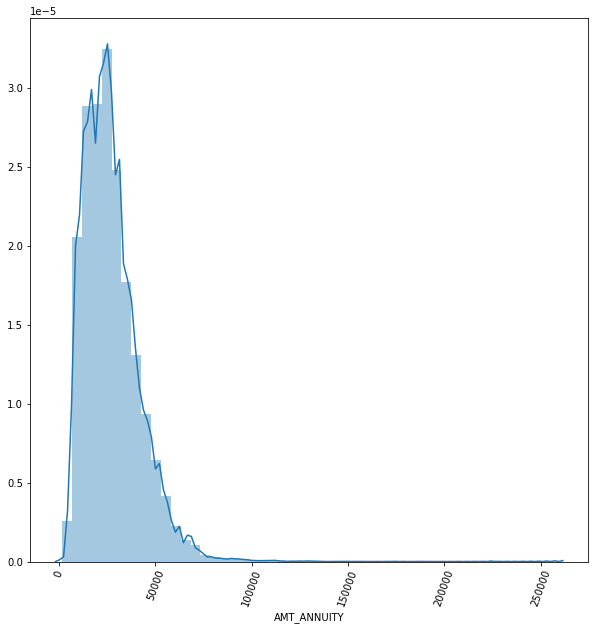

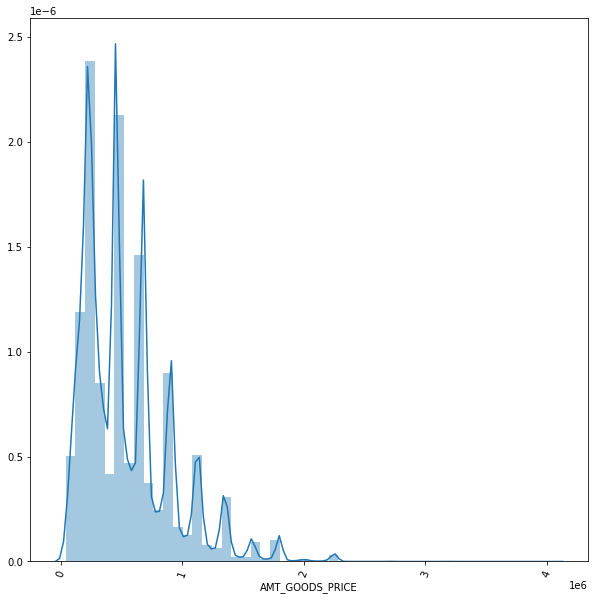

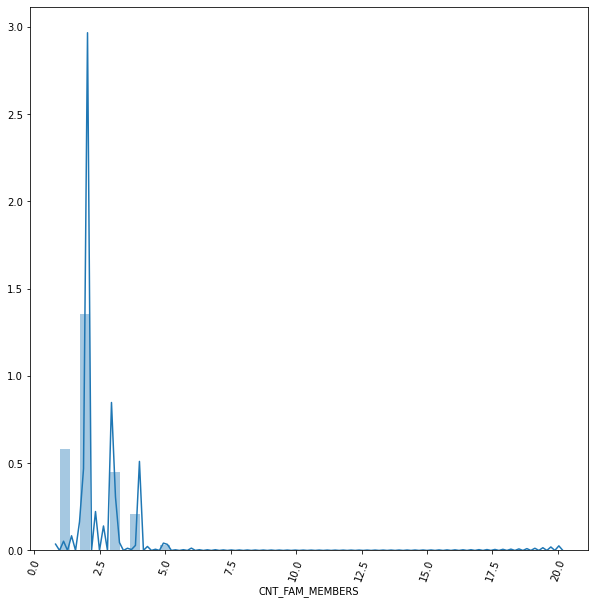

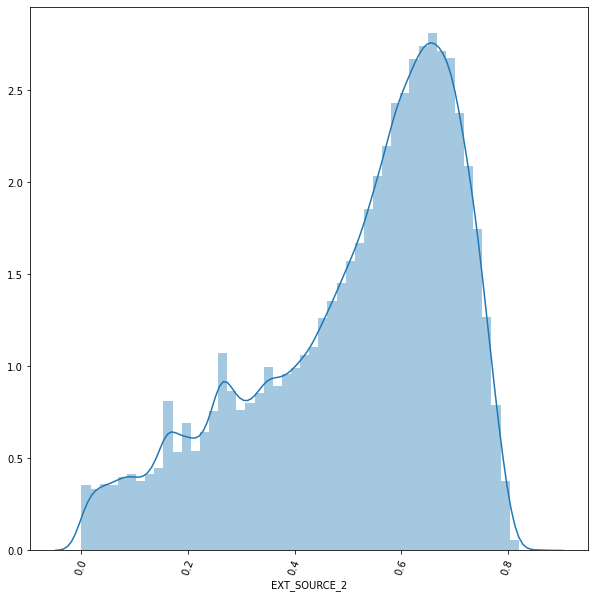

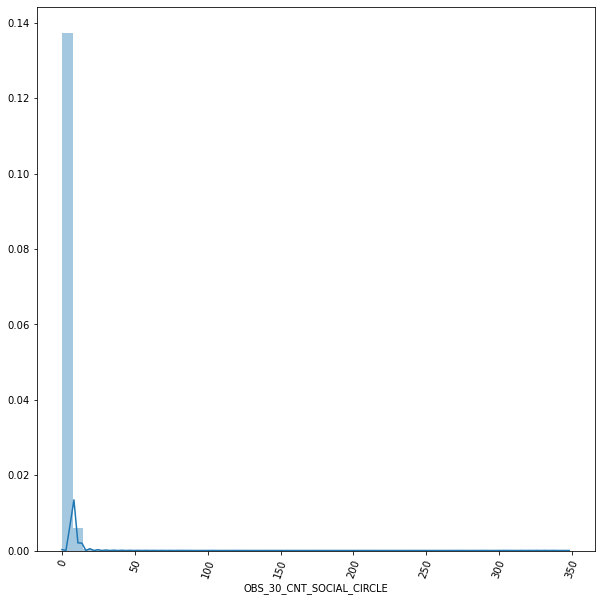

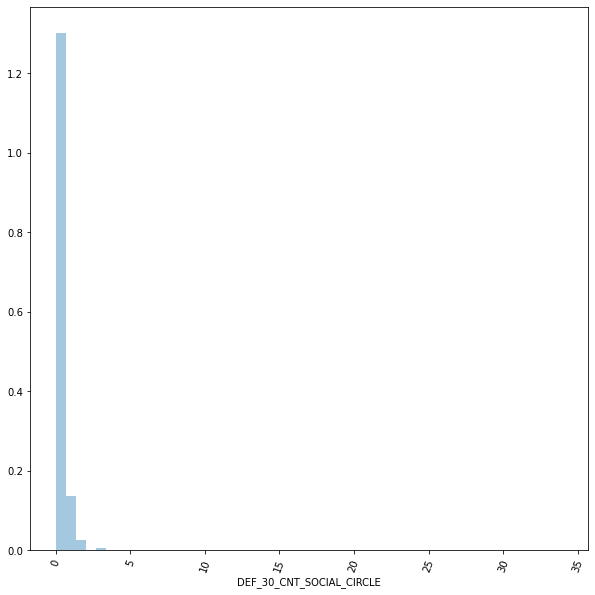

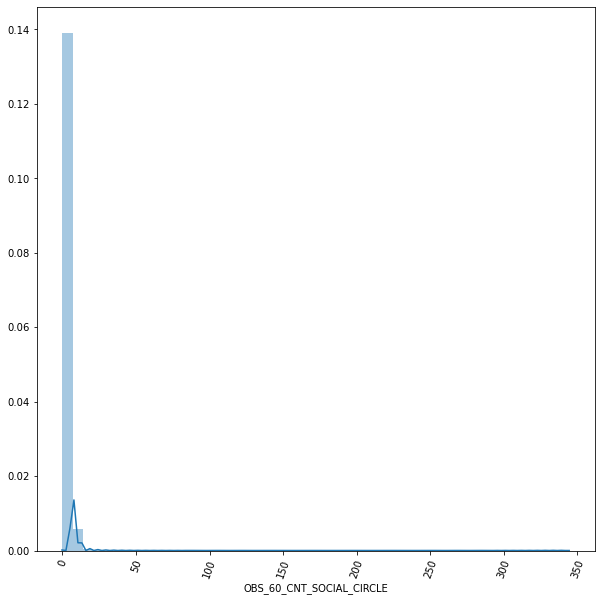

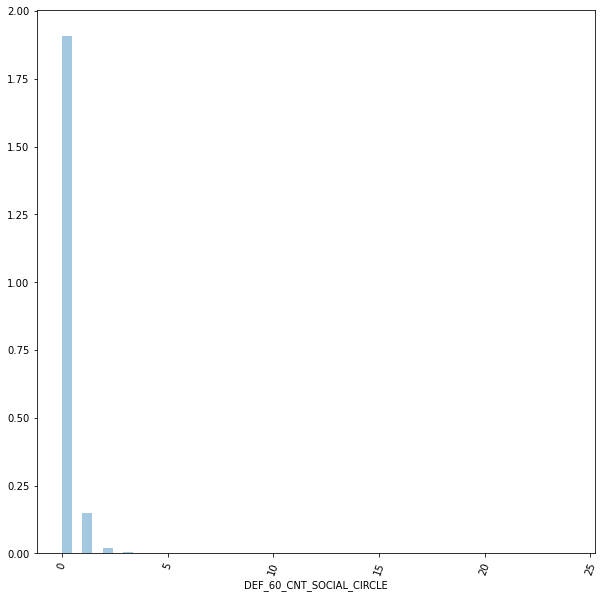

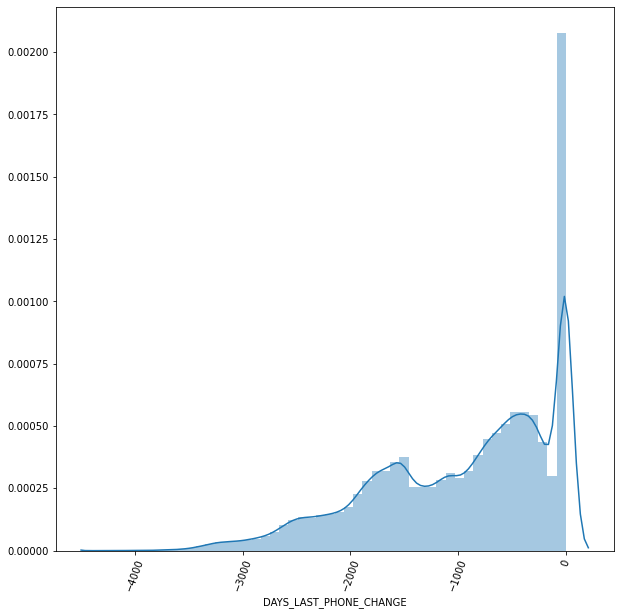

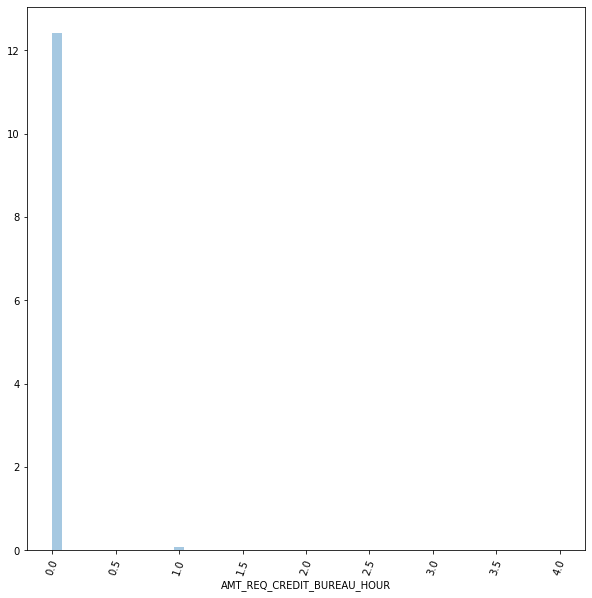

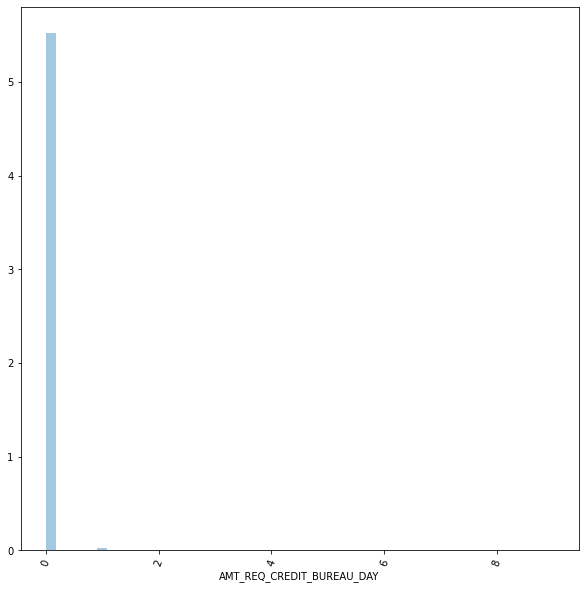

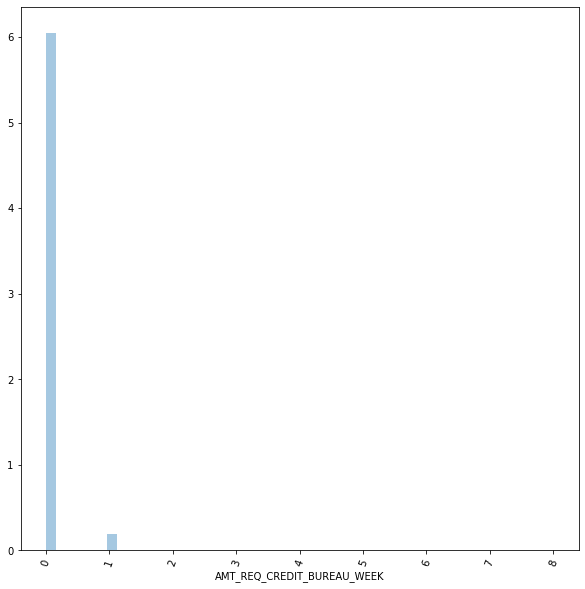

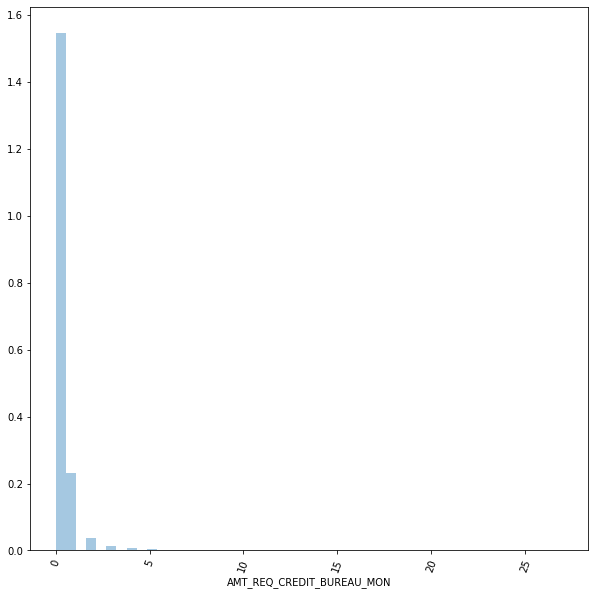

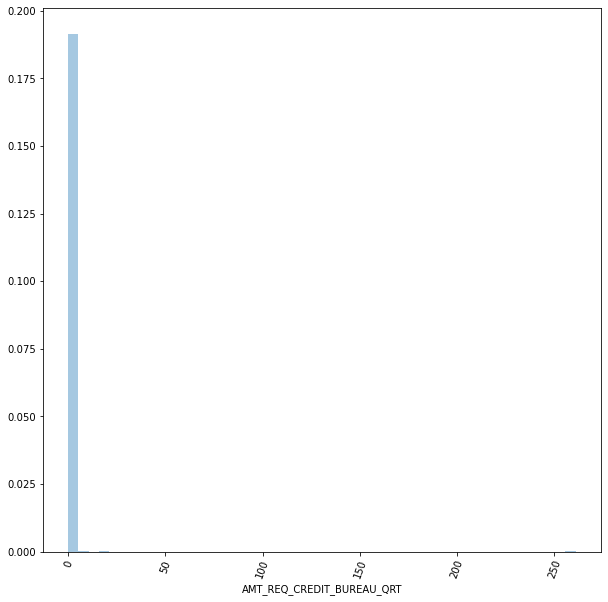

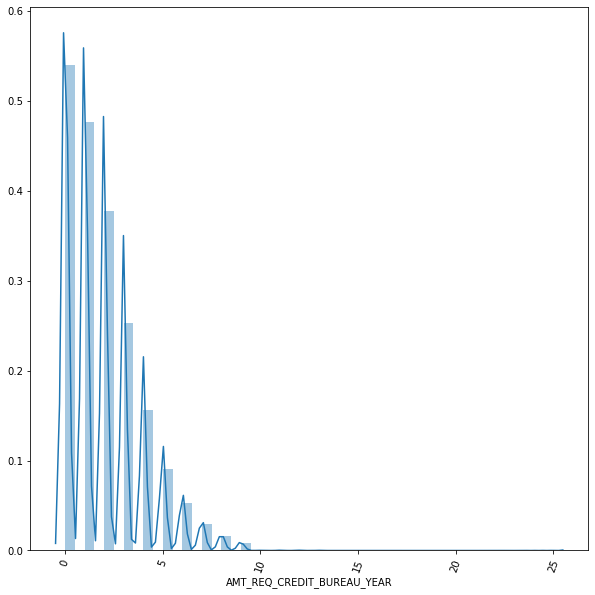

In [26]:
for i in num_columns_lower_percentage_nan:
    plt.figure(figsize=(10,10))
    sns.distplot(app_train[i])
    plt.xticks(rotation = 70)

I can see some of the features are very skewed to the right (Outliers Exists) and some aren't. So I'll impute using mode for all variables
except EXT_SOURCE_2, AMT_ANNUITY I'll use the mean as I can see from their distrbutions that the mean will be reliable value.

In [27]:
col_mod_transfrom = [i for i in num_columns_lower_percentage_nan if i not in ['EXT_SOURCE_2', 'AMT_ANNUITY','AMT_GOODS_PRICE']]
col_mean_transform = ['EXT_SOURCE_2', 'AMT_ANNUITY']

In [28]:
for i in col_mod_transfrom:
    app_test[i].fillna(app_train[i].mode()[0], inplace=True)
    app_train[i].fillna(app_train[i].mode()[0], inplace=True)

In [29]:
for i in col_mean_transform:
    app_test[i].fillna(app_train[i].mean(), inplace=True)
    app_train[i].fillna(app_train[i].mean(), inplace=True)


In [30]:
app_train['AMT_GOODS_PRICE'].fillna(app_train['AMT_GOODS_PRICE'].median(),inplace = True)
# No nulls for this column in the test data

In [31]:
# extract continuous columns
all_numerical_cols = list(app_train.select_dtypes(exclude='object').columns)

# continuous  columns are all columns excluding target and flags columns
cont_cols = [col for col in all_numerical_cols if col != "TARGET" and col[:5]!='FLAG_']

C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2211444\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserW

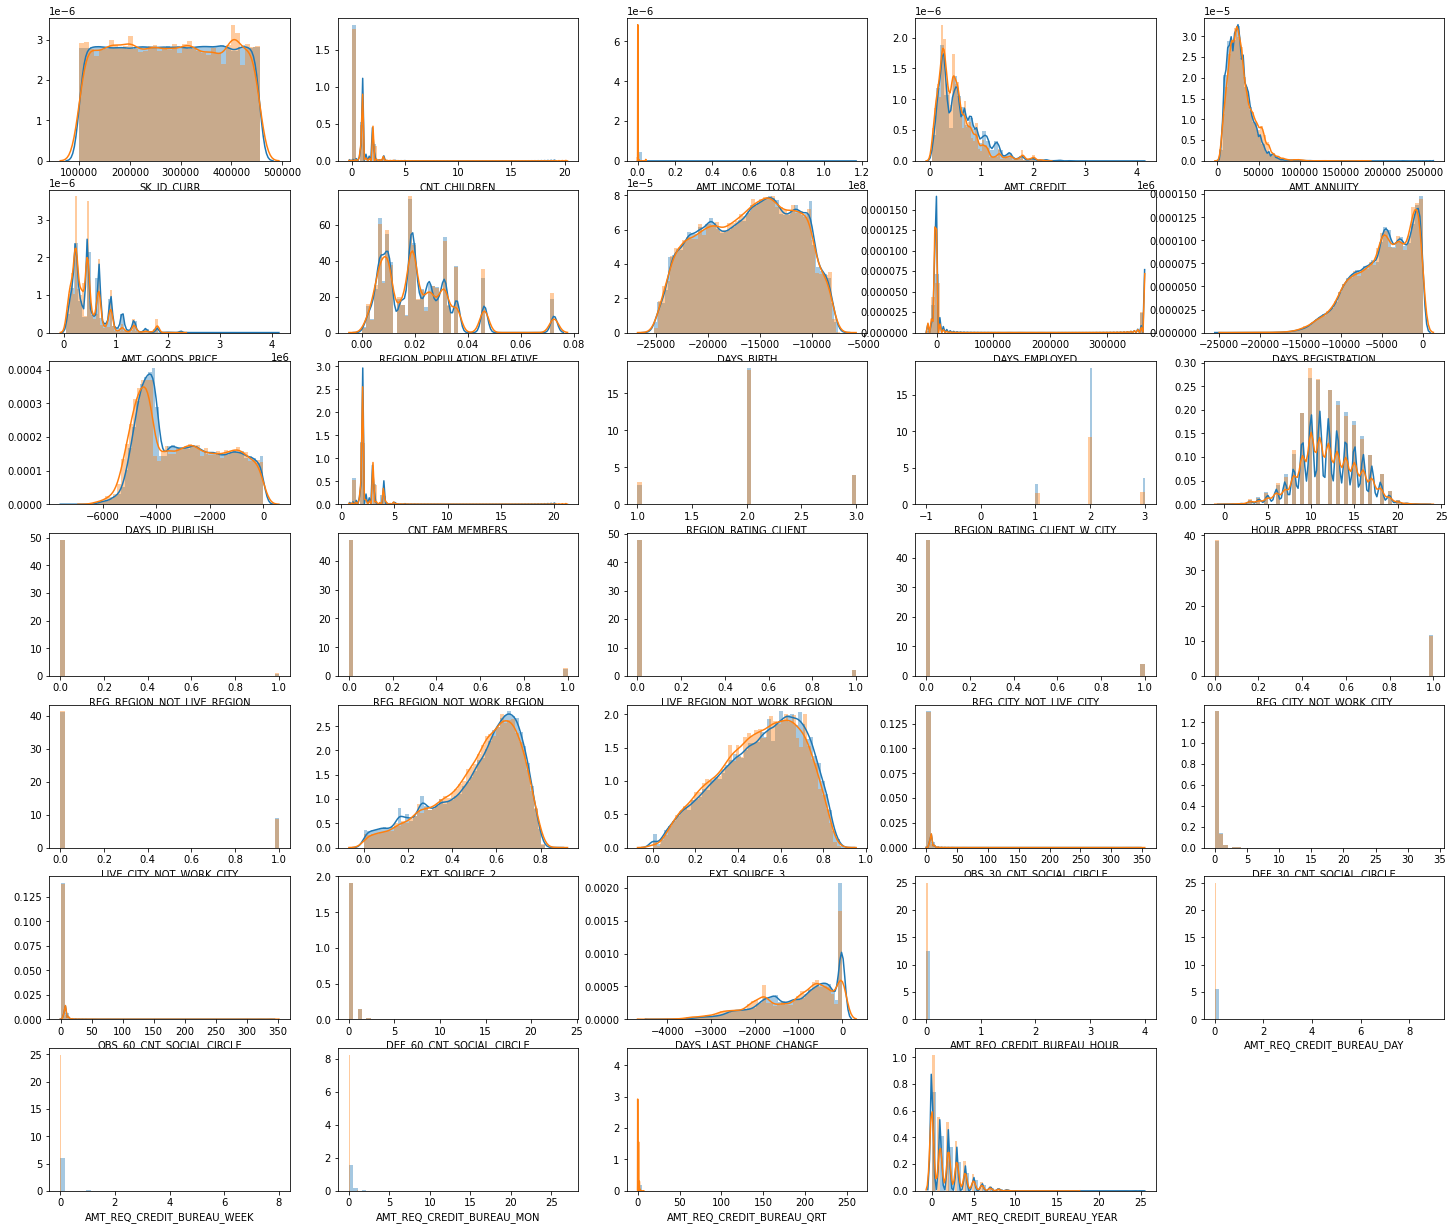

In [32]:
# draw histograms for each continuous column    
plt.figure(figsize=(25, 50))
for i, col in enumerate(cont_cols):
    plt.subplot(16, 5, i+1)
    sns.distplot(app_train[col])
    sns.distplot(app_test[col])

#### The Graphs doesn't give me much informations but we will get deeper in every columns, but for now I can just say that train and test data have the same distriputions and just some features need to get handeld

In [33]:
app_train[cont_cols[1:10]].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION
count,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383163e+05,0.020868,-16036.995067,63815.045904,-4986.120328
std,0.722121,2.371231e+05,4.024908e+05,14493.454517,3.692890e+05,0.013831,4363.988632,141275.766519,3522.886321
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000
50%,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000
75%,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000
max,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000


In [34]:
app_train[cont_cols[10:18]].describe()

,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,-2994.202373,2.152664,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659
std,1509.450419,0.910679,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499
min,-7197.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-4299.000000,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000
50%,-3254.000000,2.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000
75%,-1720.000000,3.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000
max,0.000000,20.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000


In [35]:
app_train[cont_cols[18:27]].describe()

,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
count,307511.000000,307511.000000,307511.000000,3.075110e+05,246546.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.078173,0.230454,0.179555,5.143927e-01,0.510853,1.417523,0.142944,1.400626,0.099717
std,0.268444,0.421124,0.383817,1.908550e-01,0.194844,2.398395,0.446033,2.377224,0.361735
min,0.000000,0.000000,0.000000,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.929737e-01,0.370650,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,5.654672e-01,0.535276,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,6.634218e-01,0.669057,2.000000,0.000000,2.000000,0.000000
max,1.000000,1.000000,1.000000,8.549997e-01,0.896010,348.000000,34.000000,344.000000,24.000000


In [36]:
app_train[cont_cols[27:]].describe()


,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,-962.855657,0.005538,0.006055,0.029723,0.231293,0.229631,1.643447
std,826.808966,0.078014,0.103037,0.190728,0.856810,0.744059,1.855821
min,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### Findings
* Days in negatives! it may the data source give all days data with negatives, simplly I'll multiply it by -1
* DAYS_EMPLOYED have maximum value positive and it's 1000 years, also checking this link: https://www.kaggle.com/c/home-credit-default-risk/discussion/57248 the competition hosts mention that this value means infinty which we need to deal with it
It says in the competition documentation that DAYS_EMPLOYED is 'How many days before the application the person started current employment' and the minimum value for that column is 49 years so still in the same job 50 years!! is kinda suspicious (Except for the very very loyal people which they don't exist :D )
* It seemes to me that maximum income is very suspicous as it's a very huge number comparing to Loan amount (Why someone income is 25 pounds and ask for 1 pound loan!).
* Maximum Age is 69 years old! and maximum employing time is 49 years old! -- i need to check weathr is theres any one have a number of employing days more than the number of birth days (Note: you will see the minimum in days is 69 years but as the values are negatives so we will consider as maximum)

### Deal with unreal value for DAYS_EMPLOYED

In [38]:
# Check whether is there inconsistent data 
app_train[(abs(app_train['DAYS_BIRTH']) < abs(app_train['DAYS_EMPLOYED'])) & (app_train['DAYS_EMPLOYED'] != 365243)]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


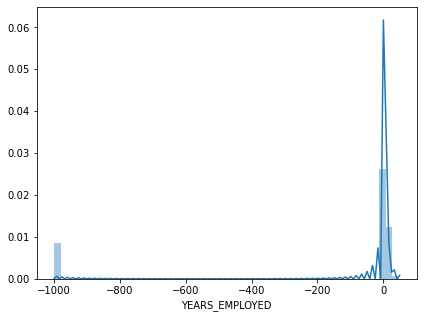

In [39]:
proper_days_empolyed_df = app_train
proper_days_empolyed_df['YEARS_EMPLOYED'] = proper_days_empolyed_df['DAYS_EMPLOYED']/-365.25

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(proper_days_empolyed_df['YEARS_EMPLOYED'])

In [40]:
# I'll convert all values with 365243 to NaN then I will fill it with ( Average Employment time group by the OCCUPATION_TYPE)

app_train['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True) 
app_test['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

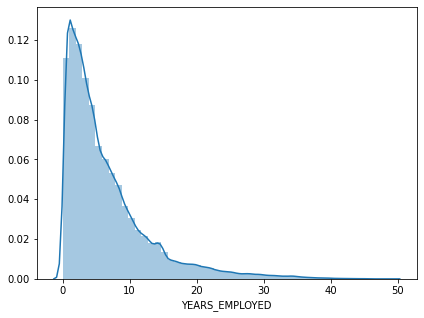

In [41]:
proper_days_empolyed_df = app_train
proper_days_empolyed_df['YEARS_EMPLOYED'] = proper_days_empolyed_df['DAYS_EMPLOYED']/-365.25

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(proper_days_empolyed_df['YEARS_EMPLOYED'])

In [42]:
# See the average years between the Days_birth and Days_employed but also I will depend on the OCCUPATION_TYPE 

app_train.groupby(['OCCUPATION_TYPE'])['DAYS_EMPLOYED'].mean()

OCCUPATION_TYPE
Accountants             -2394.102823
Cleaning staff          -2131.155665
Cooking staff           -2152.466868
Core staff              -2797.755967
Drivers                 -1939.034618
HR staff                -2278.866785
High skill tech staff   -2739.979086
IT staff                -2095.570342
Laborers                -2424.143152
Low-skill Laborers      -1664.186813
Managers                -2759.318937
Medicine staff          -3750.265550
Private service staff   -2238.281297
Realty agents           -1785.003995
Sales staff             -1703.789421
Secretaries             -2607.050575
Security staff          -1904.809106
Waiters/barmen staff    -1873.172849
Name: DAYS_EMPLOYED, dtype: float64

### I'll impute it using occupation_TYPE but first I need to impute the occupation type

In [43]:
# Tha maximum income of a the clients is about 30 times the maximum amount of the loans

## create dataframe with total income > 1M
susp_df1 = app_train[app_train['AMT_INCOME_TOTAL']>1e+6][['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','CNT_CHILDREN', 'TARGET']].sort_values(by='AMT_INCOME_TOTAL', ascending=False)

## create Credit/Income and Annuity/Income percentages
susp_df1['Credit/Income'] = susp_df1['AMT_CREDIT']/susp_df1['AMT_INCOME_TOTAL']
susp_df1['Annuity/Income'] = susp_df1['AMT_ANNUITY']/susp_df1['AMT_INCOME_TOTAL']

## show only clients with difficuties
susp_df1[susp_df1['TARGET']==1].sort_values(by='Credit/Income', ascending=True)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,TARGET,Credit/Income,Annuity/Income
12840,117000000.0,562491.0,26194.5,1,1,0.004808,0.000224
248159,3150000.0,900000.0,48825.0,1,1,0.285714,0.015500
151018,1080000.0,371245.5,17437.5,0,1,0.343746,0.016146
167656,1575000.0,553806.0,28273.5,0,1,0.351623,0.017951
173663,1350000.0,491211.0,50463.0,3,1,0.363860,0.037380
41725,1890000.0,781920.0,61906.5,1,1,0.413714,0.032755
234728,1350000.0,576072.0,28017.0,0,1,0.426720,0.020753
248970,1890000.0,900000.0,57649.5,0,1,0.476190,0.030502
265884,1170000.0,983299.5,41661.0,1,1,0.840427,0.035608
234861,1260000.0,1097491.5,46629.0,0,1,0.871025,0.037007


1st record with Credit/Income < 0.005 and income over 117 million is not logical. It must be wrong.
I'll drop it for now but if there's any additional time, of course I will investigate in it

In [44]:
app_train = app_train[app_train['AMT_INCOME_TOTAL'] != 117000000.0]

In [45]:
# The maximum age of a client is 69 year

## extract dataframe with DAYS_BIRTH and TARGET only
susp_df2 = app_train[['DAYS_BIRTH','TARGET']]

## create column represnts the age in years
susp_df2['YEARS_BIRTH'] = np.abs(susp_df2['DAYS_BIRTH']) / 365.25

## show datafame
display(susp_df2.sort_values(by='YEARS_BIRTH', ascending=False))

## show the value counts of those who are aged > 65 with respect to target
display(susp_df2[(susp_df2['YEARS_BIRTH']>65)]['TARGET'].value_counts())

<ipython-input-45-da4b5c07fe23>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  susp_df2['YEARS_BIRTH'] = np.abs(susp_df2['DAYS_BIRTH']) / 365.25


,DAYS_BIRTH,TARGET,YEARS_BIRTH
265026,-25229,0,69.073238
63316,-25201,0,68.996578
124430,-25201,0,68.996578
143266,-25200,0,68.993840
130108,-25197,0,68.985626
...,...,...,...
220805,-7678,1,21.021218
170384,-7676,0,21.015743
53702,-7676,0,21.015743
168135,-7673,0,21.007529


0    7588
1     288
Name: TARGET, dtype: int64

In [46]:
cat_col = app_train.select_dtypes('object')
cat_col.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
count,307510,307510,307510,307510,307510,307510,307510,307510,307510,211119,307510,252136
unique,2,2,2,2,7,8,5,5,6,18,7,57
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3
freq,278231,202451,202923,213311,249817,158773,218390,196433,272867,55185,53900,67991


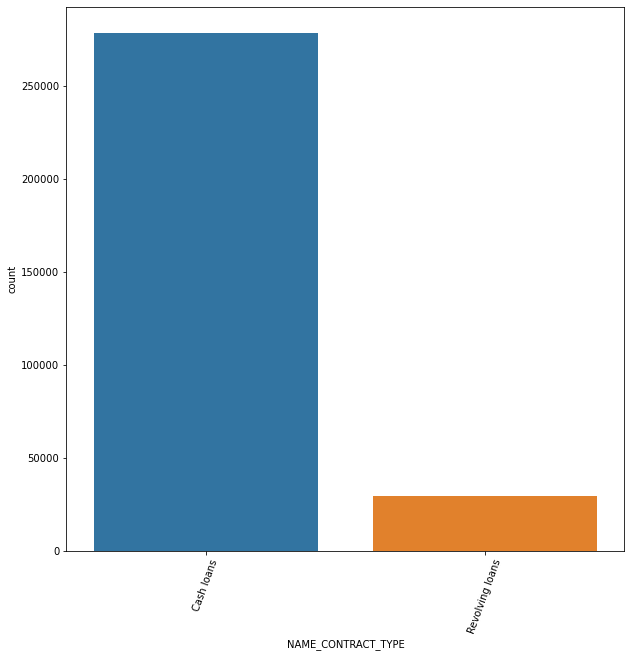

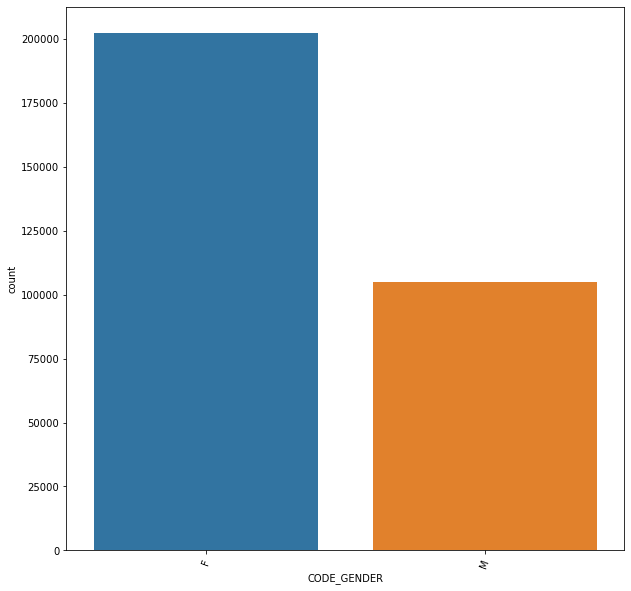

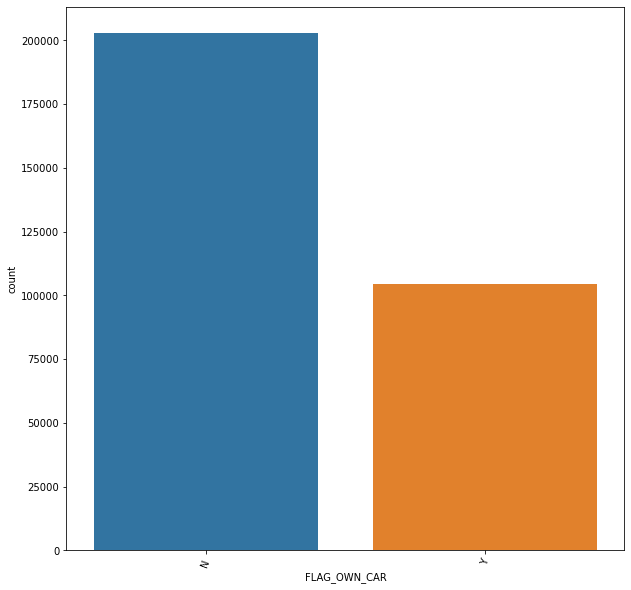

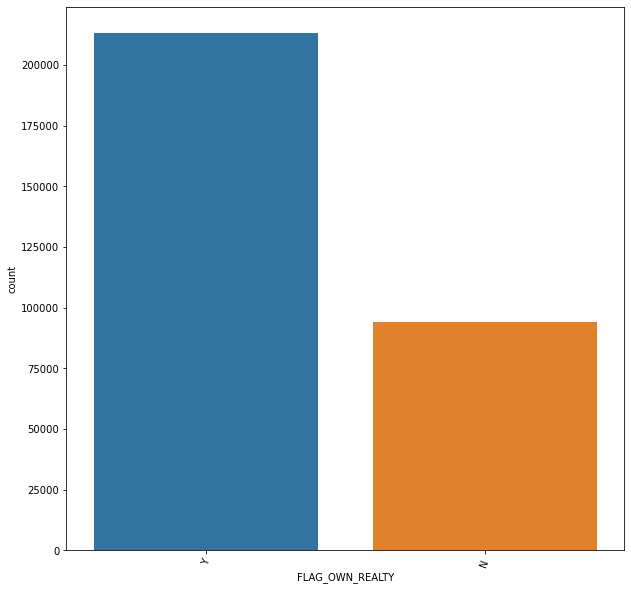

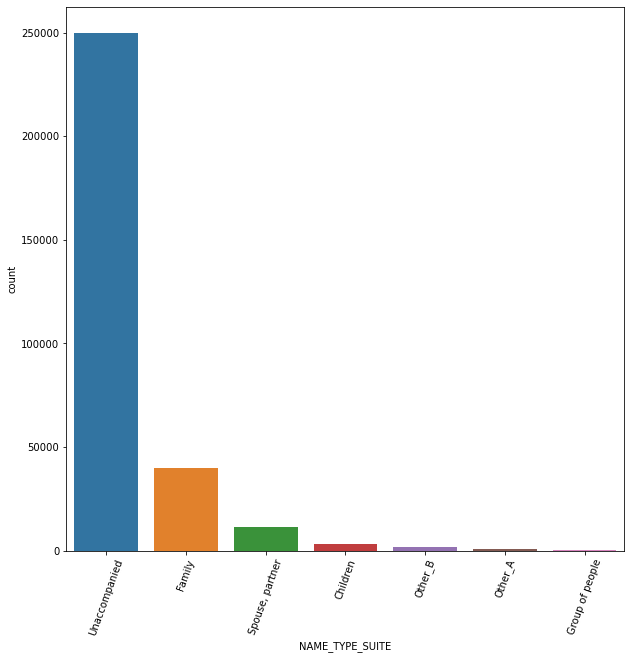

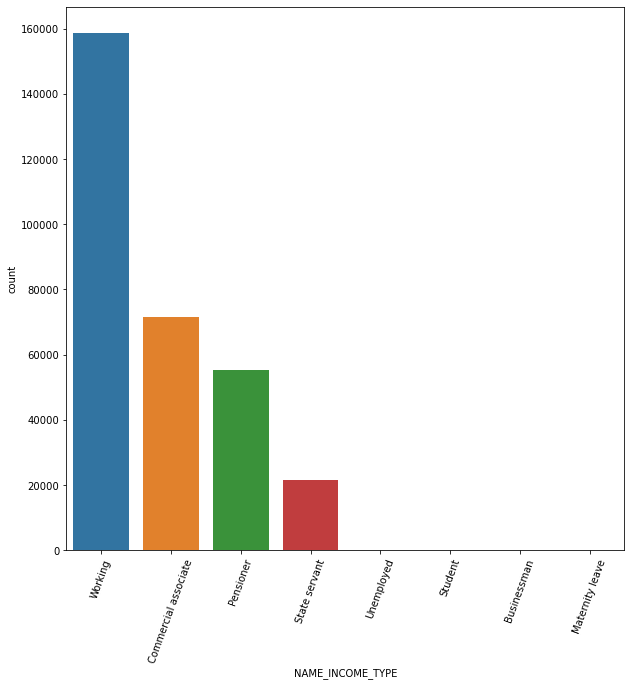

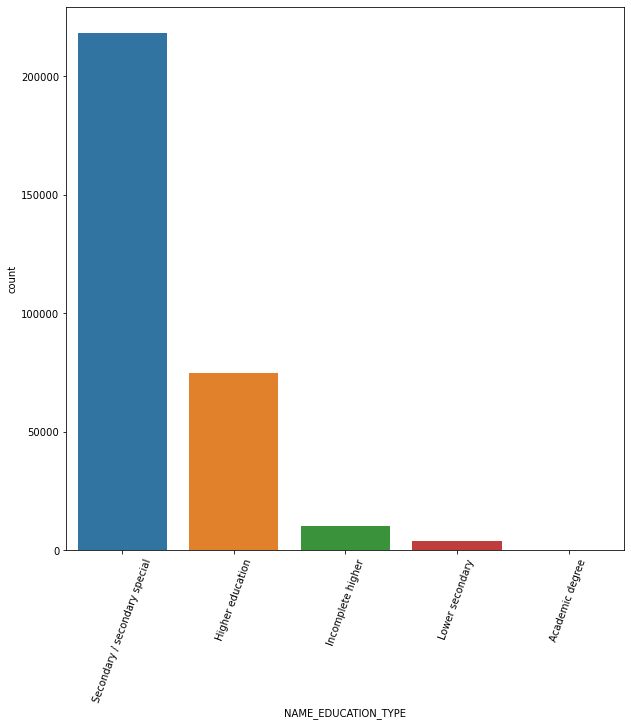

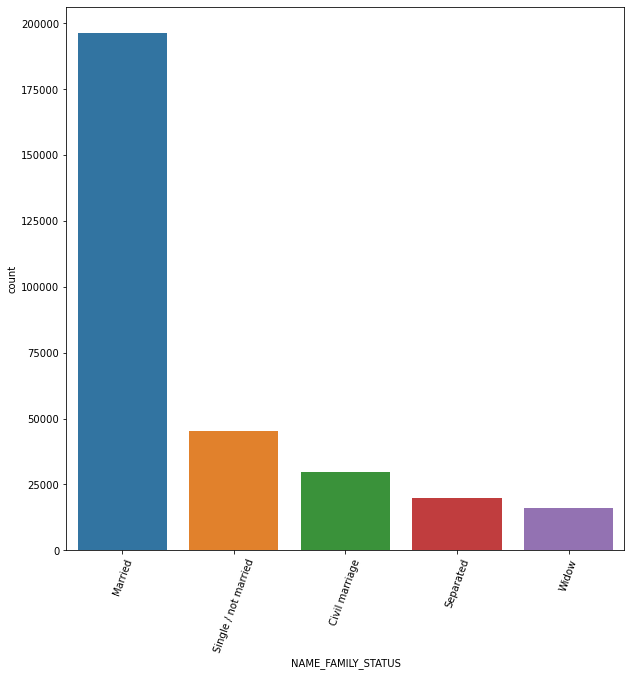

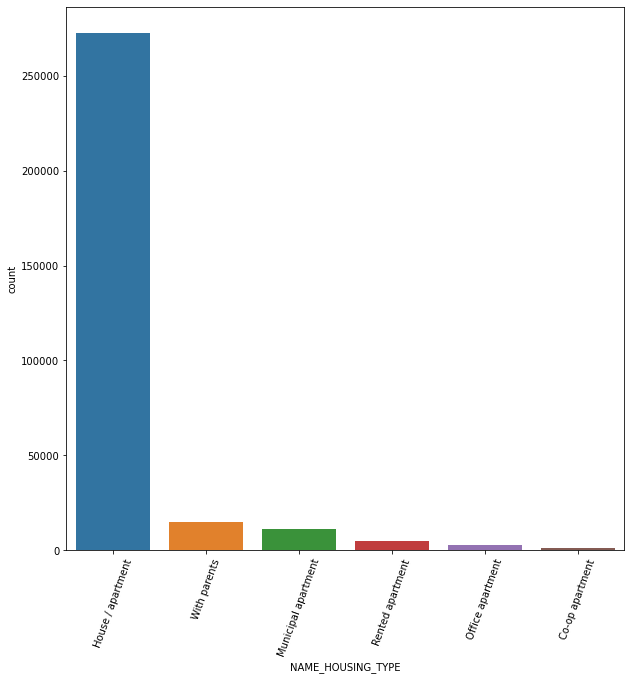

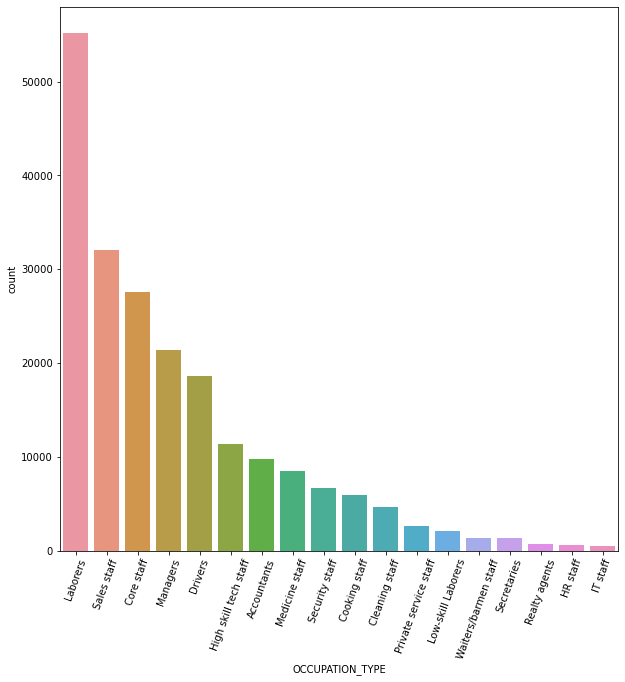

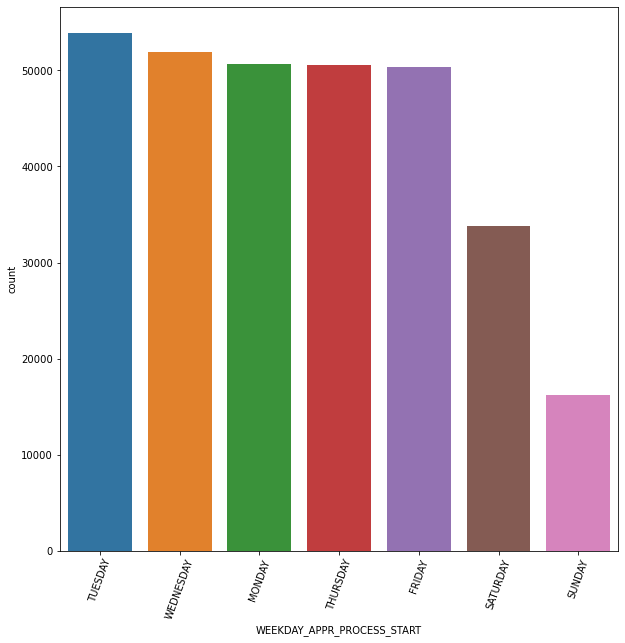

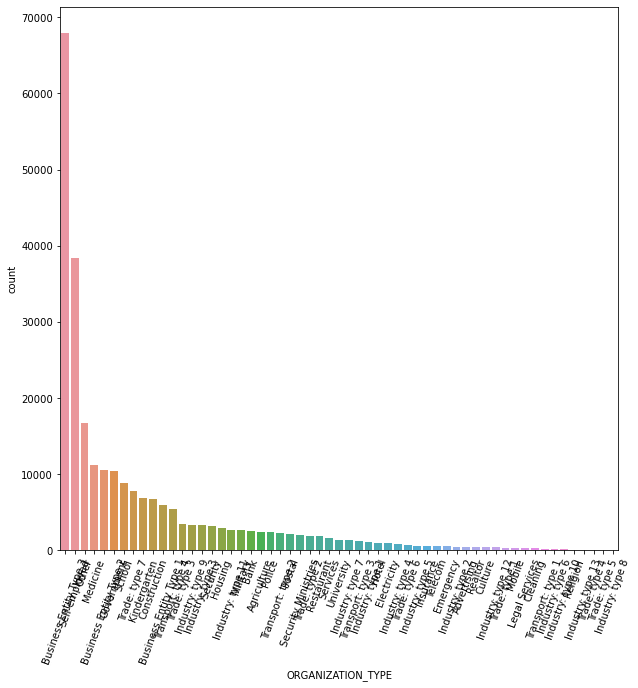

In [47]:
for i in cat_col:
    plt.figure(figsize=(10,10))
    sns.countplot(cat_col[i], orient = 'h', order = cat_col[i].value_counts().index)
    plt.xticks(rotation = 70)

Action will make for simpler data and filling the NaNs
* NAME_TYPE_SUIT will shorten the categories and merge Other_A, Other_B and Group of people to same Group called Others
* NAME_INCOME_TYPE will shorten the categories and merge Unemployed, student, Maternity leave to same group as logically all of them don't have source of money so will behave similarly regarding the target value
* ORGNIZATION_TYPE I'll take around 10-15 category and merge others to same group called Other
* we have +30% of OCCUPATION_TYPE in train and test data is NaNs, I'll fill it using the mode groupping by the NAME_EDUCATION_TYPE because it's the most reasonable column who can refer to the occupation type
* we have +17% of EXT_SOURCE_3 in train and test data is NaNs, I'll fill it using the mean groupping by the OCUPPATION_TYPE
* we have +18% of ORGNIZATION_TYPE in train and test data is NaNs, I'll fill it using the mode groupping by the OCUPPATION_TYPE


In [48]:
app_train.groupby(['NAME_EDUCATION_TYPE'])['OCCUPATION_TYPE'].agg(pd.Series.mode)


NAME_EDUCATION_TYPE
Academic degree                    Managers
Higher education                 Core staff
Incomplete higher                  Laborers
Lower secondary                    Laborers
Secondary / secondary special      Laborers
Name: OCCUPATION_TYPE, dtype: object

In [49]:
app_train['OCCUPATION_TYPE'].isnull().sum()
app_test['OCCUPATION_TYPE'].isnull().sum()

15605

In [50]:
app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Secondary / secondary special'] = app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Secondary / secondary special'].fillna('Laborers')
app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Higher education'] =  app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Higher education'].fillna('Core staff')
app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Incomplete higher'] = app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Incomplete higher'].fillna('Laborers')
app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Lower secondary'] = app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Lower secondary'].fillna('Laborers')
app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Academic degree'] = app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Academic degree'].fillna('Managers')

app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Secondary / secondary special'] = app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Secondary / secondary special'].fillna('Laborers')
app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Higher education'] =  app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Higher education'].fillna('Core staff')
app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Incomplete higher'] = app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Incomplete higher'].fillna('Laborers')
app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Lower secondary'] = app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Lower secondary'].fillna('Laborers')
app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Academic degree'] = app_test['OCCUPATION_TYPE'][app_test['NAME_EDUCATION_TYPE']=='Academic degree'].fillna('Managers')

<ipython-input-50-3e482c76d290>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Secondary / secondary special'] = app_train['OCCUPATION_TYPE'][app_train['NAME_EDUCATION_TYPE']=='Secondary / secondary special'].fillna('Laborers')
C:\Users\2211444\Anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-50-3e482c76d290>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [51]:
app_train.groupby(['OCCUPATION_TYPE'])['ORGANIZATION_TYPE'].agg(pd.Series.mode)

OCCUPATION_TYPE
Accountants              Business Entity Type 3
Cleaning staff           Business Entity Type 3
Cooking staff            Business Entity Type 3
Core staff               Business Entity Type 3
Drivers                  Business Entity Type 3
HR staff                 Business Entity Type 3
High skill tech staff    Business Entity Type 3
IT staff                 Business Entity Type 3
Laborers                 Business Entity Type 3
Low-skill Laborers       Business Entity Type 3
Managers                 Business Entity Type 3
Medicine staff                         Medicine
Private service staff             Self-employed
Realty agents                     Self-employed
Sales staff                       Self-employed
Secretaries                            Medicine
Security staff                         Security
Waiters/barmen staff     Business Entity Type 3
Name: ORGANIZATION_TYPE, dtype: object

In [52]:
app_train['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Accountants') |
                               (app_train['OCCUPATION_TYPE'] == 'Cleaning staff') |
                               (app_train['OCCUPATION_TYPE'] == 'Cooking staff') |
                               (app_train['OCCUPATION_TYPE'] == 'Core staff')|
                               (app_train['OCCUPATION_TYPE'] == 'Drivers')|
                               (app_train['OCCUPATION_TYPE'] == 'HR staff')|
                               (app_train['OCCUPATION_TYPE'] == 'High skill tech staff')|
                               (app_train['OCCUPATION_TYPE'] == 'IT staff')|
                               (app_train['OCCUPATION_TYPE'] == 'Laborers')|
                               (app_train['OCCUPATION_TYPE'] == 'Low-skill Laborers')|
                               (app_train['OCCUPATION_TYPE'] == 'Managers')] = app_train['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Accountants') |
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'Cleaning staff') |
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'Cooking staff') |
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'Core staff')|
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'Drivers')|
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'HR staff')|
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'High skill tech staff')|
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'IT staff')|
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'Laborers')|
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'Low-skill Laborers')|
                                                                                                             (app_train['OCCUPATION_TYPE'] == 'Managers')].fillna('Business Entity Type 3')

app_test['ORGANIZATION_TYPE'][(app_test['OCCUPATION_TYPE'] == 'Accountants') |
                               (app_test['OCCUPATION_TYPE'] == 'Cleaning staff') |
                               (app_test['OCCUPATION_TYPE'] == 'Cooking staff') |
                               (app_test['OCCUPATION_TYPE'] == 'Core staff')|
                               (app_test['OCCUPATION_TYPE'] == 'Drivers')|
                               (app_test['OCCUPATION_TYPE'] == 'HR staff')|
                               (app_test['OCCUPATION_TYPE'] == 'High skill tech staff')|
                               (app_test['OCCUPATION_TYPE'] == 'IT staff')|
                               (app_test['OCCUPATION_TYPE'] == 'Laborers')|
                               (app_test['OCCUPATION_TYPE'] == 'Low-skill Laborers')|
                               (app_test['OCCUPATION_TYPE'] == 'Managers')] = app_test['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Accountants') |
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'Cleaning staff') |
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'Cooking staff') |
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'Core staff')|
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'Drivers')|
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'HR staff')|
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'High skill tech staff')|
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'IT staff')|
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'Laborers')|
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'Low-skill Laborers')|
                                                                                                            (app_test['OCCUPATION_TYPE'] == 'Managers')].fillna('Business Entity Type 3')


app_train['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Medicine staff')|
                              (app_train['OCCUPATION_TYPE'] == 'Secretaries')] = app_train['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Medicine staff')|
                                                                                                                  (app_train['OCCUPATION_TYPE'] == 'Secretaries')].fillna('Medicine')
app_test['ORGANIZATION_TYPE'][(app_test['OCCUPATION_TYPE'] == 'Medicine staff')|
                              (app_test['OCCUPATION_TYPE'] == 'Secretaries')] = app_test['ORGANIZATION_TYPE'][(app_test['OCCUPATION_TYPE'] == 'Medicine staff')|
                                                                                                                  (app_test['OCCUPATION_TYPE'] == 'Secretaries')].fillna('Medicine')
app_train['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Private service staff')|
                               (app_train['OCCUPATION_TYPE'] == 'Realty agents')|
                               (app_train['OCCUPATION_TYPE'] == 'Sales staff')] = app_train['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Private service staff')|
                                                                                                                 (app_train['OCCUPATION_TYPE'] == 'Realty agents')|
                                                                                                                 (app_train['OCCUPATION_TYPE'] == 'Sales staff')].fillna('Self-employed')
app_test['ORGANIZATION_TYPE'][(app_test['OCCUPATION_TYPE'] == 'Private service staff')|
                               (app_test['OCCUPATION_TYPE'] == 'Realty agents')|
                               (app_test['OCCUPATION_TYPE'] == 'Sales staff')] = app_test['ORGANIZATION_TYPE'][(app_test['OCCUPATION_TYPE'] == 'Private service staff')|
                                                                                                                 (app_test['OCCUPATION_TYPE'] == 'Realty agents')|
                                                                                                                 (app_test['OCCUPATION_TYPE'] == 'Sales staff')].fillna('Self-employed')

app_train['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Security staff')] = app_train['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Security staff')].fillna('Security')
app_test['ORGANIZATION_TYPE'][(app_test['OCCUPATION_TYPE'] == 'Security staff')] = app_test['ORGANIZATION_TYPE'][(app_test['OCCUPATION_TYPE'] == 'Security staff')].fillna('Security')

<ipython-input-52-ce2a87638641>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_train['ORGANIZATION_TYPE'][(app_train['OCCUPATION_TYPE'] == 'Accountants') |
<ipython-input-52-ce2a87638641>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_test['ORGANIZATION_TYPE'][(app_test['OCCUPATION_TYPE'] == 'Accountants') |
<ipython-input-52-ce2a87638641>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_train['ORGANIZATION_TYPE'][(ap

In [53]:
app_test['ORGANIZATION_TYPE'] = app_test['ORGANIZATION_TYPE'].fillna(app_test['ORGANIZATION_TYPE'].mode()[0]) # Just because there's 3% of the NaN didn't get imputed by the last approach 

In [54]:
app_test['EXT_SOURCE_3'] = app_test['EXT_SOURCE_3'].fillna(app_train.groupby(['OCCUPATION_TYPE'])['EXT_SOURCE_3'].transform('mean'))
app_train['EXT_SOURCE_3'] = app_train['EXT_SOURCE_3'].fillna(app_train.groupby(['OCCUPATION_TYPE'])['EXT_SOURCE_3'].transform('mean'))

<ipython-input-54-0a2c7bd4f24d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_train['EXT_SOURCE_3'] = app_train['EXT_SOURCE_3'].fillna(app_train.groupby(['OCCUPATION_TYPE'])['EXT_SOURCE_3'].transform('mean'))


In [55]:
# Note, as I said before, I always fill the test data by the train data indormation to avoid any data leakage 

app_test['DAYS_EMPLOYED'] = app_test['DAYS_EMPLOYED'].fillna(app_train.groupby(['OCCUPATION_TYPE'])['DAYS_EMPLOYED'].transform('mean'))
app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].fillna(app_train.groupby(['OCCUPATION_TYPE'])['DAYS_EMPLOYED'].transform('mean'))

<ipython-input-55-9e88432bf7be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].fillna(app_train.groupby(['OCCUPATION_TYPE'])['DAYS_EMPLOYED'].transform('mean'))


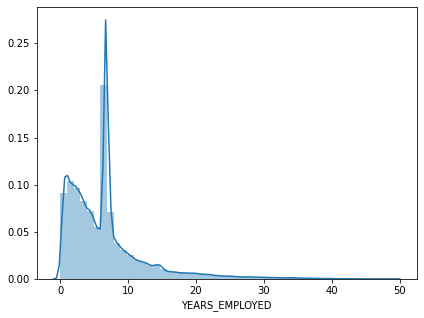

In [56]:
proper_days_empolyed_df = app_train
proper_days_empolyed_df['YEARS_EMPLOYED'] = proper_days_empolyed_df['DAYS_EMPLOYED']/-365.25

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(proper_days_empolyed_df['YEARS_EMPLOYED'])

In [57]:
app_test['NAME_TYPE_SUITE'].replace({'Other_A':'Other','Other_B':'Other','Group of people':'Other'},inplace=True)
app_train['NAME_TYPE_SUITE'].replace({'Other_A':'Other','Other_B':'Other','Group of people':'Other'},inplace=True)

app_test['NAME_INCOME_TYPE'].replace({'Unemployed':'Other','Student':'Other','Maternity leave':'Other'},inplace=True)
app_train['NAME_INCOME_TYPE'].replace({'Unemployed':'Other','Student':'Other','Maternity leave':'Other'},inplace=True)

In [58]:
# I'll take Only the first 15 Categories and I'll convirt the rest to "Others" not "Other" because we already have a group called "Other: and i want to put them in a different group
app_train['ORGANIZATION_TYPE'].value_counts(normalize = True)

Business Entity Type 3    0.401174
Self-employed             0.124913
Other                     0.054252
Medicine                  0.036399
Business Entity Type 2    0.034318
Government                0.033833
School                    0.028919
Trade: type 7             0.025466
Kindergarten              0.022373
Construction              0.021856
Business Entity Type 1    0.019460
Transport: type 4         0.017554
Trade: type 3             0.011356
Industry: type 9          0.010952
Industry: type 3          0.010660
Security                  0.010559
Housing                   0.009619
Industry: type 11         0.008793
Military                  0.008566
Bank                      0.008153
Agriculture               0.007980
Police                    0.007613
Transport: type 2         0.007167
Postal                    0.007014
Security Ministries       0.006419
Trade: type 2             0.006179
Restaurant                0.005889
Services                  0.005122
University          

In [59]:
others = app_train['ORGANIZATION_TYPE'].value_counts().index[15:]
label = 'Others'
app_train['ORGANIZATION_TYPE'] = app_train['ORGANIZATION_TYPE'].replace(others, label)
app_test['ORGANIZATION_TYPE'] = app_test['ORGANIZATION_TYPE'].replace(others, label)

In [60]:
app_train['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Others',
       'Other', 'Medicine', 'Business Entity Type 2', 'Self-employed',
       'Construction', 'Kindergarten', 'Trade: type 7',
       'Transport: type 4', 'Business Entity Type 1', 'Trade: type 3',
       'Industry: type 3', 'Industry: type 9'], dtype=object)

In [61]:
users_nan = (app_train.isnull().sum() / app_train.shape[0]) * 100
users_nan[users_nan > 0].sort_values(ascending=False)

Series([], dtype: float64)

In [62]:
users_nan = (app_test.isnull().sum() / app_test.shape[0]) * 100
users_nan[users_nan > 0].sort_values(ascending=False)

Series([], dtype: float64)

In [63]:
app_train.drop(['YEARS_EMPLOYED'], axis = 1,inplace=True)

In [64]:
app_train.shape

(307510, 73)

In [65]:
app_test.shape

(48744, 72)

### Now let's work on our target variable

In [66]:
print(app_train['TARGET'].isnull().sum())

0


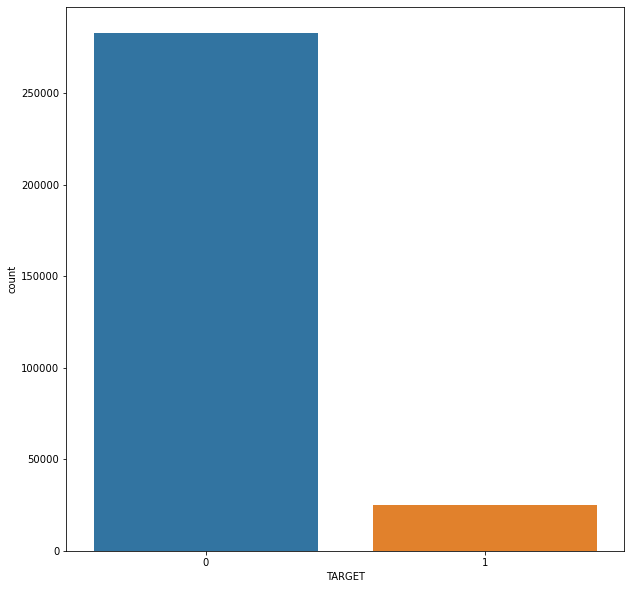

In [67]:
plt.figure(figsize=(10,10))
sns.countplot(app_train['TARGET'])

#### We observe that there is imbalance in the dataset and we need to balance it.

In [68]:
# It's very obvious that we have imbalanced data, class(1) is about 8% of the data
app_train['TARGET'].value_counts(normalize=True).reset_index()


,index,TARGET
0,0,0.919274
1,1,0.080726


### Data is imbalanced so:
I'll Consider tha class_weight solution for this problem when we go to the modeling phase (We can use under smapling or over sampling but for me because of the huge difference between both classes, class weight is the best solution)
Accuracy is not a proper evaluation metric, it will be misleading so we will need to check another metric (e.g. roc_auc).

Class weight is a technique that can be used to address this issue in the context of classification models.

When training a model on imbalanced data, the model may become biased towards the majority class, and may have difficulty accurately predicting the minority class. To address this, class weight assigns a higher weight to the minority class and a lower weight to the majority class during training. This means that the model will pay more attention to the minority class, and will try to improve its predictions for that class

### Bivariate Anaylsis
Does the gender can indicate anything about the target

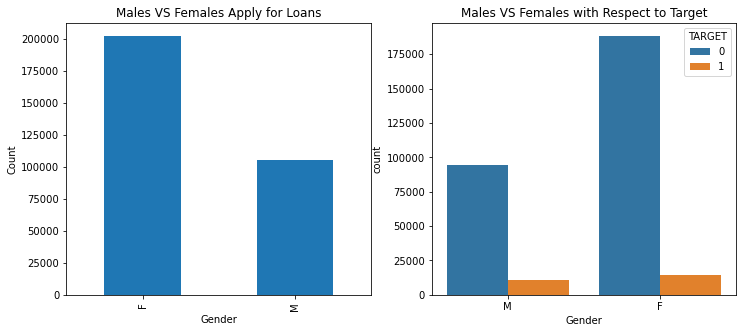

F    0.658356
M    0.341644
Name: CODE_GENDER, dtype: float64
----------------------------------------
TARGET  CODE_GENDER
0       F              0.666046
        M              0.333954
1       F              0.570778
        M              0.429222
Name: CODE_GENDER, dtype: float64
----------------------------------------
CODE_GENDER  TARGET
F            0         0.930013
             1         0.069987
M            0         0.898581
             1         0.101419
Name: TARGET, dtype: float64


In [69]:
# Which gender applys more for loans?
# Is there relation between the gender and the ability to repay?

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
app_train['CODE_GENDER'].value_counts().plot(kind='bar', title='Males VS Females Apply for Loans');
plt.xlabel('Gender')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(data=app_train, x='CODE_GENDER', hue='TARGET');
plt.title('Males VS Females with Respect to Target')
plt.xlabel('Gender')
plt.show()

print(app_train['CODE_GENDER'].value_counts(normalize=True))
print('-'*40)
print(app_train.groupby(['TARGET'])['CODE_GENDER'].value_counts(normalize=True))
print('-'*40)
print(app_train.groupby(['CODE_GENDER'])['TARGET'].value_counts(normalize=True))

* Females applys for loans more than Males
* Gender not affect in our Target because the difference between the gender are only 3% ( we can't relay on it)

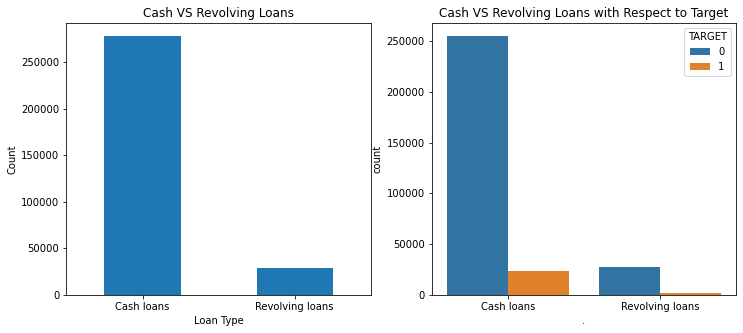

Cash loans         0.904787
Revolving loans    0.095213
Name: NAME_CONTRACT_TYPE, dtype: float64
----------------------------------------
TARGET  NAME_CONTRACT_TYPE
0       Cash loans            0.902100
        Revolving loans       0.097900
1       Cash loans            0.935385
        Revolving loans       0.064615
Name: NAME_CONTRACT_TYPE, dtype: float64


In [71]:
# Which type of loan contract clients applys more for?

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
app_train['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar', title='Cash VS Revolving Loans');
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
sns.countplot(data=app_train, x='NAME_CONTRACT_TYPE', hue='TARGET')
plt.title('Cash VS Revolving Loans with Respect to Target')
plt.xlabel('.')
plt.show()

print(app_train['NAME_CONTRACT_TYPE'].value_counts(normalize=True))
print('-'*40)
print(app_train.groupby(['TARGET'])['NAME_CONTRACT_TYPE'].value_counts(normalize=True))

* Most of the clients take cash loans
* It seems to me that this feature has no effect on the target

<ipython-input-72-12e171dd8546>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proper_day_birth_df['DAYS_BIRTH'] = proper_day_birth_df['DAYS_BIRTH']/-365.25


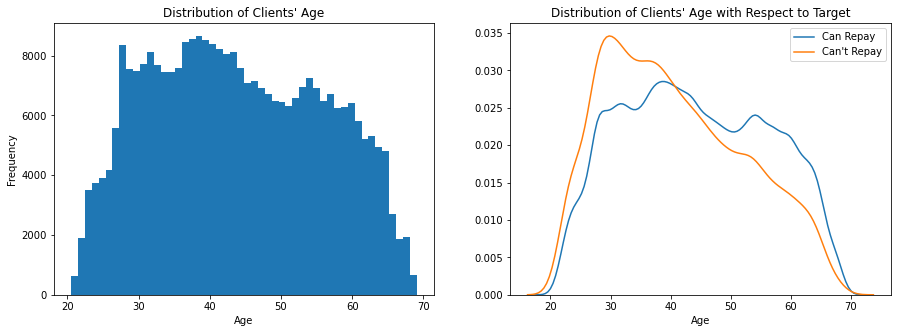

In [72]:
# Is there relation between the age and the ability to repay?

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
(app_train['DAYS_BIRTH']/-365.25).plot(kind='hist', bins=50, title='Distribution of Clients\' Age');
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
proper_day_birth_df = app_train[['DAYS_BIRTH', 'TARGET']]
proper_day_birth_df['DAYS_BIRTH'] = proper_day_birth_df['DAYS_BIRTH']/-365.25
sns.distplot(proper_day_birth_df[proper_day_birth_df['TARGET']==0]['DAYS_BIRTH'], hist=False, label='Can Repay');
sns.distplot(proper_day_birth_df[proper_day_birth_df['TARGET']==1]['DAYS_BIRTH'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Clients\' Age with Respect to Target')
plt.xlabel('Age')
plt.legend();
plt.show()

Clients aged about 30 years are more likely to have difficulties with repay, where those aged about 40 and more can repay well.
This feature will be important for the model.

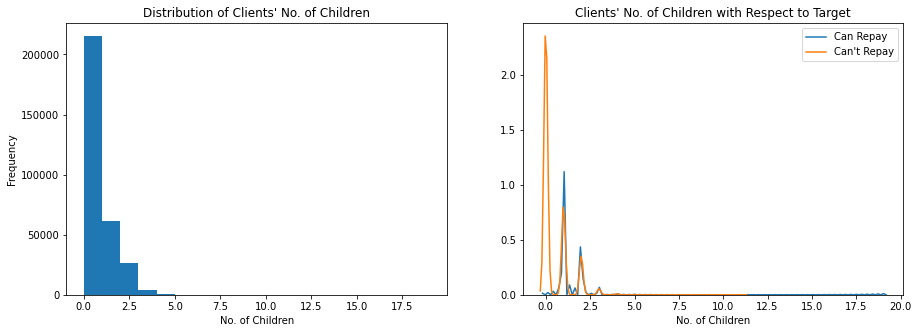

In [73]:
# Does the client's No. of children affect the ability to repay?

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
app_train['CNT_CHILDREN'].plot(kind='hist', bins=19, title='Distribution of Clients\' No. of Children');
plt.xlabel('No. of Children')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.distplot(app_train[app_train['TARGET']==0]['CNT_CHILDREN'], hist=False, label='Can Repay');
sns.distplot(app_train[app_train['TARGET']==1]['CNT_CHILDREN'], hist=False, label='Can\'t Repay');
plt.title('Clients\' No. of Children with Respect to Target')
plt.xlabel('No. of Children')
plt.legend()
plt.show()

* Client's without any children applys for loans more than others, and with increasing No. of children, client's don't tend to loan

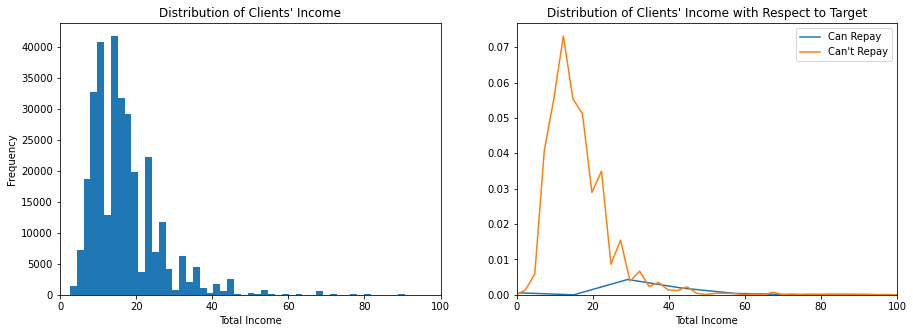

In [74]:
# Is there a relation between client income ant the amount of loan apply for?
# Does income and credit affect in the ability to repay?

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
proper_income_df = app_train
proper_income_df['AMT_INCOME_TOTAL'] = proper_income_df['AMT_INCOME_TOTAL']/10000
proper_income_df['AMT_INCOME_TOTAL'].plot(kind='hist', bins=1000, title='Distribution of Clients\' Income');
plt.xlabel('Total Income')
plt.xlim([0,100])

plt.subplot(1, 2, 2)
sns.distplot(proper_income_df[proper_income_df['TARGET']==0]['AMT_INCOME_TOTAL'], hist=False, bins=1000, label='Can Repay');
sns.distplot(proper_income_df[proper_income_df['TARGET']==1]['AMT_INCOME_TOTAL'], hist=False, bins=1000, label='Can\'t Repay');
plt.title('Distribution of Clients\' Income with Respect to Target')
plt.xlabel('Total Income')
plt.xlim([0,100])
plt.legend();
plt.show()

<Figure size 576x576 with 0 Axes>

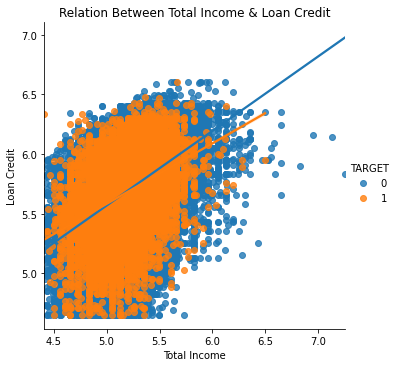

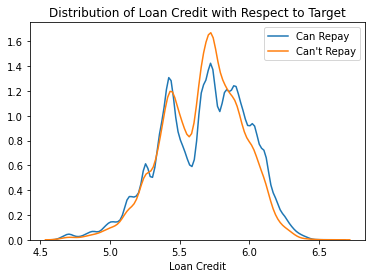

In [75]:
# let's normalize to see the plot properly
proper_income_df['log_AMT_INCOME_TOTAL'] = np.log10(proper_income_df['AMT_INCOME_TOTAL']*10000)
proper_income_df['log_AMT_CREDIT'] = np.log10(proper_income_df['AMT_CREDIT'])

plt.figure(figsize=(8,8))
sns.lmplot(x='log_AMT_INCOME_TOTAL', y='log_AMT_CREDIT', data=proper_income_df, hue='TARGET');
plt.title('Relation Between Total Income & Loan Credit')
plt.xlabel('Total Income')
plt.ylabel('Loan Credit')
plt.show()

sns.distplot(proper_income_df[proper_income_df['TARGET']==0]['log_AMT_CREDIT'], hist=False, label='Can Repay');
sns.distplot(proper_income_df[proper_income_df['TARGET']==1]['log_AMT_CREDIT'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Loan Credit with Respect to Target');
plt.xlabel('Loan Credit')
plt.legend();

* Client's with low income tends to apply for loans more than others with high income.
* The more client's income is, the larger loan amount apply for.
* Client't with income more than 3M tends always to repay, so this feature may help in our target (Frist Graph on the right)
* Clients with income between 10 and 18 are less likely to repay, vice versa. (Frist Graph on the right)
* We can see that Loan Credit isn't affected by the Target Distirbution

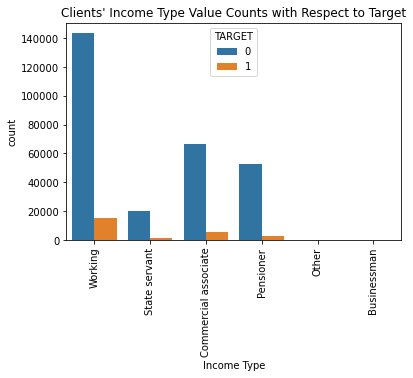

NAME_INCOME_TYPE      TARGET
Businessman           0             10
Commercial associate  0          66257
                      1           5360
Other                 0             35
                      1             10
Pensioner             0          52380
                      1           2982
State servant         0          20454
                      1           1249
Working               0         143550
                      1          15223
Name: TARGET, dtype: int64

In [76]:
# what's most income type of clients?

ax = sns.countplot(data=app_train, x='NAME_INCOME_TYPE', hue='TARGET');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);
plt.title('Clients\' Income Type Value Counts with Respect to Target')
plt.xlabel('Income Type')
plt.show()

print('\n'*2)
app_train.groupby('NAME_INCOME_TYPE')['TARGET'].value_counts()

* Working clients are more willing to apply for loans more than others.
* Altought a few businessmen and students apply for loans, but they always repay.

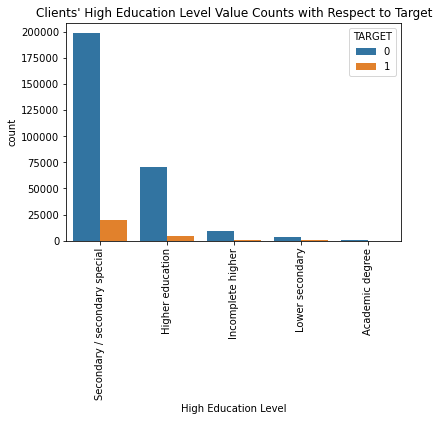

NAME_EDUCATION_TYPE            TARGET
Academic degree                0            161
                               1              3
Higher education               0          70854
                               1           4009
Incomplete higher              0           9405
                               1            872
Lower secondary                0           3399
                               1            417
Secondary / secondary special  0         198867
                               1          19523
Name: TARGET, dtype: int64

In [77]:
# what's most high education degree for clients?

ax = sns.countplot(data=app_train, x='NAME_EDUCATION_TYPE', hue='TARGET');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);
plt.title('Clients\' High Education Level Value Counts with Respect to Target')
plt.xlabel('High Education Level')
plt.show()

print('\n'*2)
app_train.groupby('NAME_EDUCATION_TYPE')['TARGET'].value_counts()

* Clients with Secondary high education level are more willing to apply for loans more than others.
* Almost 98% of clients with Academic degree high education level can repay their loans.

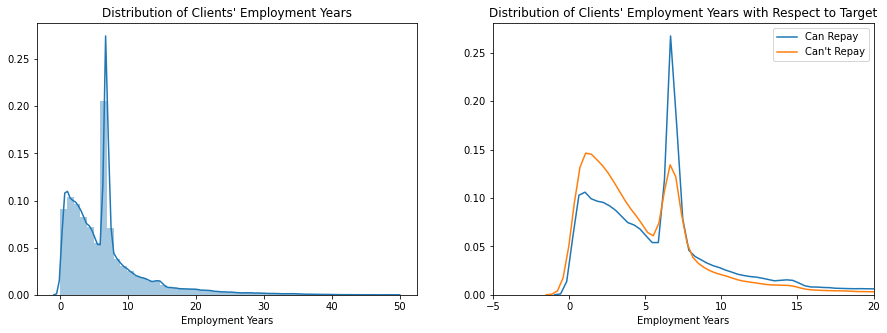

In [79]:
# IS there relation between employment year and the ability to repay

proper_days_empolyed_df = app_train
proper_days_empolyed_df['YEARS_EMPLOYED'] = proper_days_empolyed_df['DAYS_EMPLOYED']/-365.25

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(proper_days_empolyed_df['YEARS_EMPLOYED'])
plt.title('Distribution of Clients\' Employment Years')
plt.xlabel('Employment Years')

plt.subplot(1, 2, 2)
sns.distplot(proper_days_empolyed_df[proper_days_empolyed_df['TARGET']==0]['YEARS_EMPLOYED'], hist=False, label='Can Repay');
sns.distplot(proper_days_empolyed_df[proper_days_empolyed_df['TARGET']==1]['YEARS_EMPLOYED'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Clients\' Employment Years with Respect to Target');
plt.xlim([-5,20])
plt.xlabel('Employment Years')
plt.legend()

* The peek in the graph is because of the imputation, but I believe it was our best approach as we did in the imputation by groupping the occupation type
* Clients with employment years less than 5 years tend to apply for loans more than others, and they are less likely to repay, especially less than 2 years, vice versa

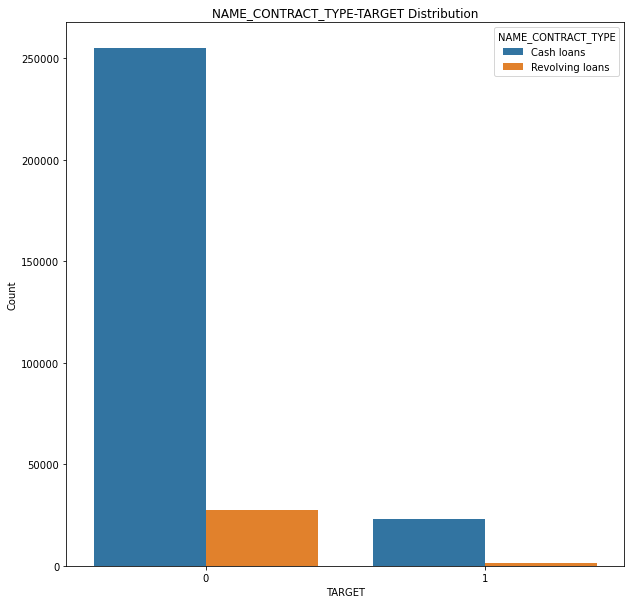

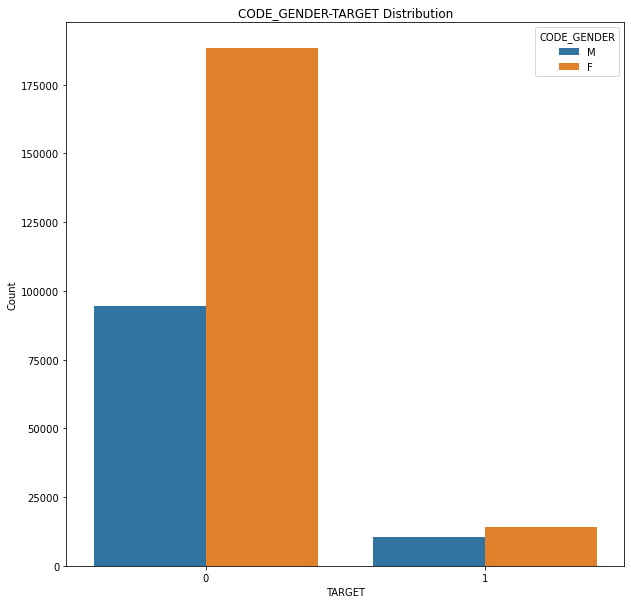

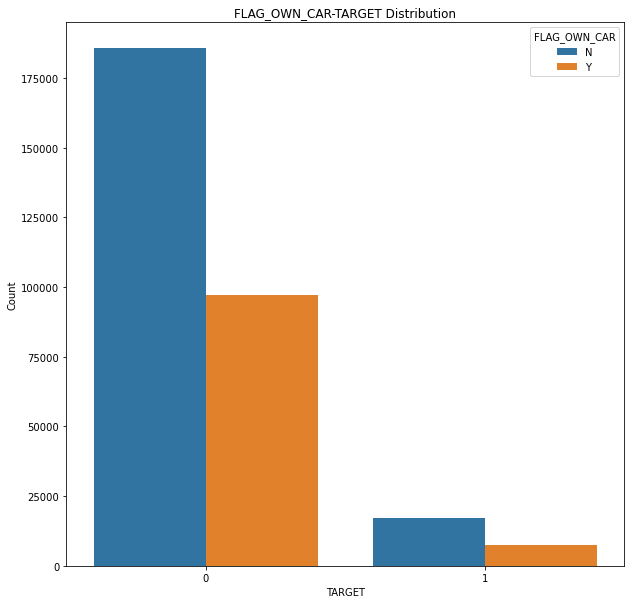

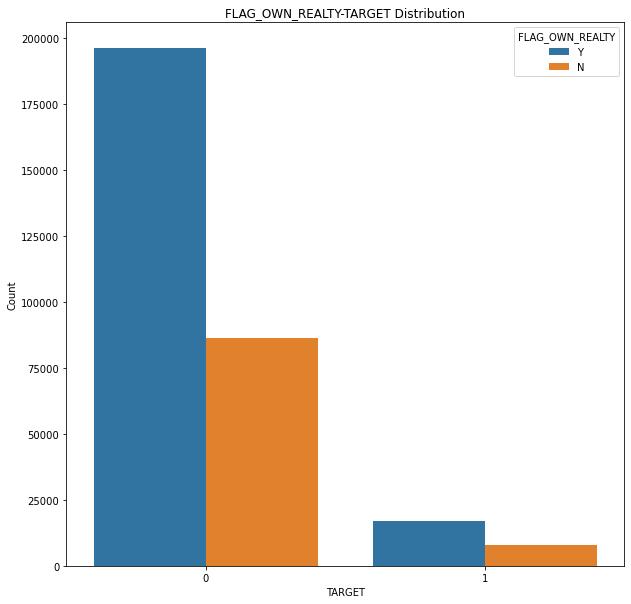

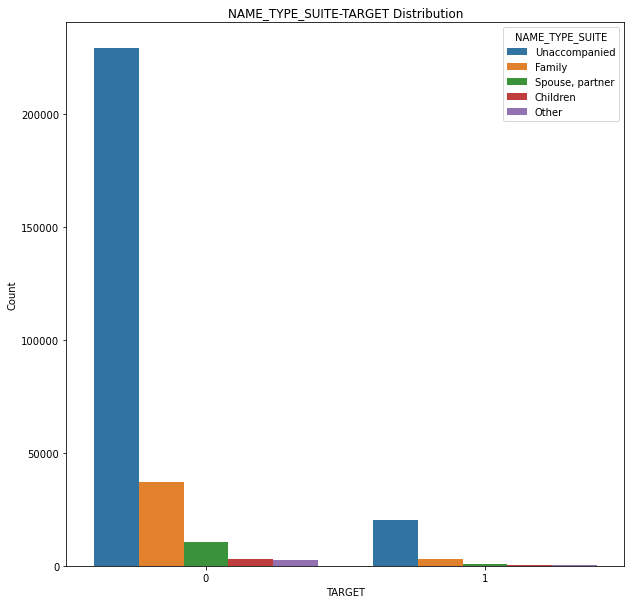

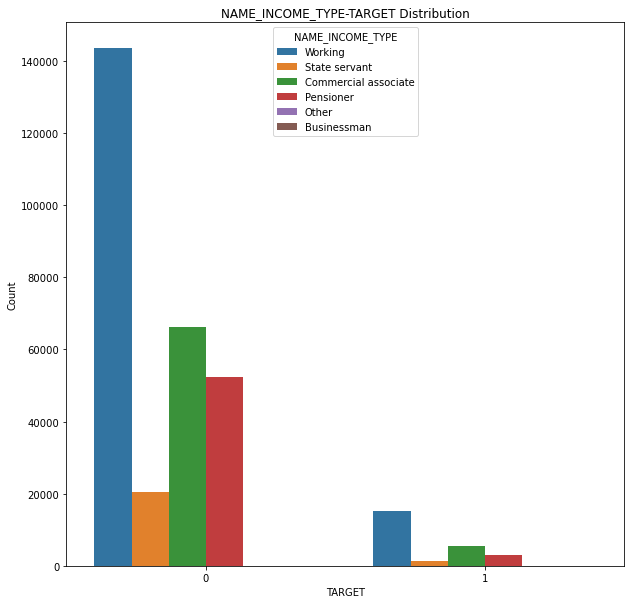

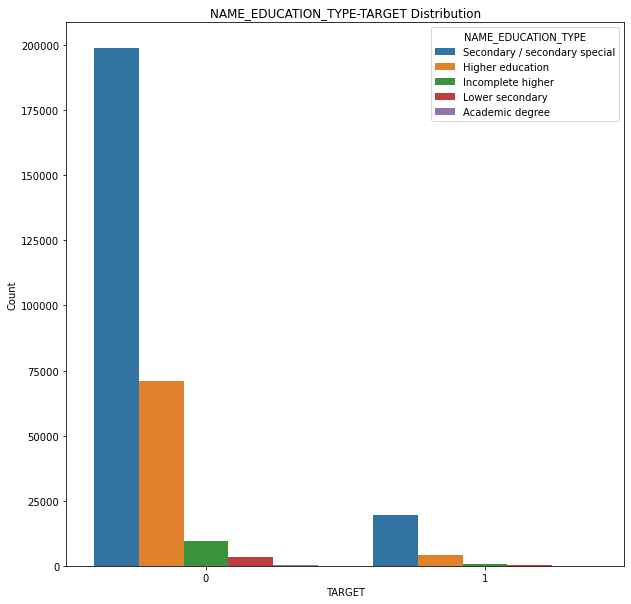

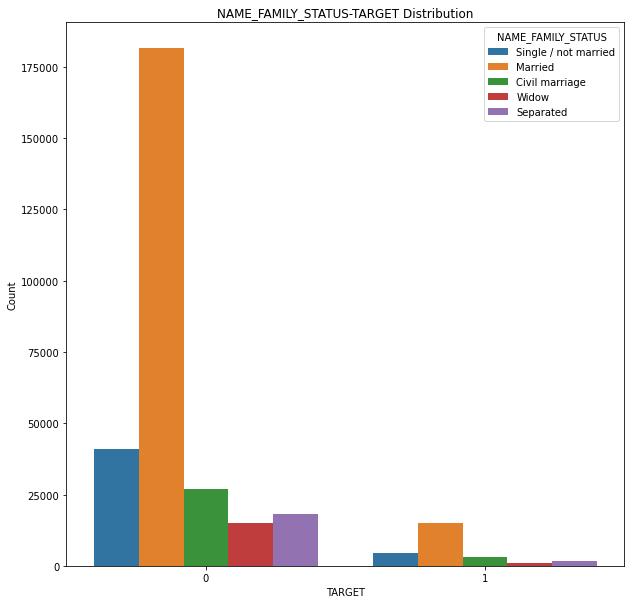

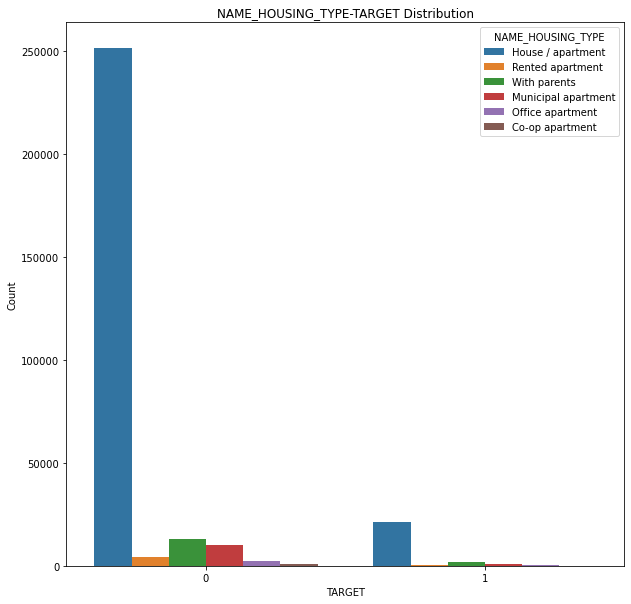

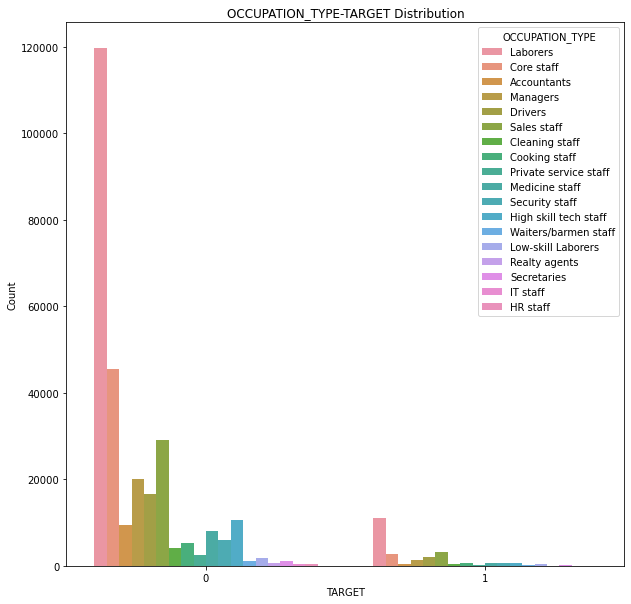

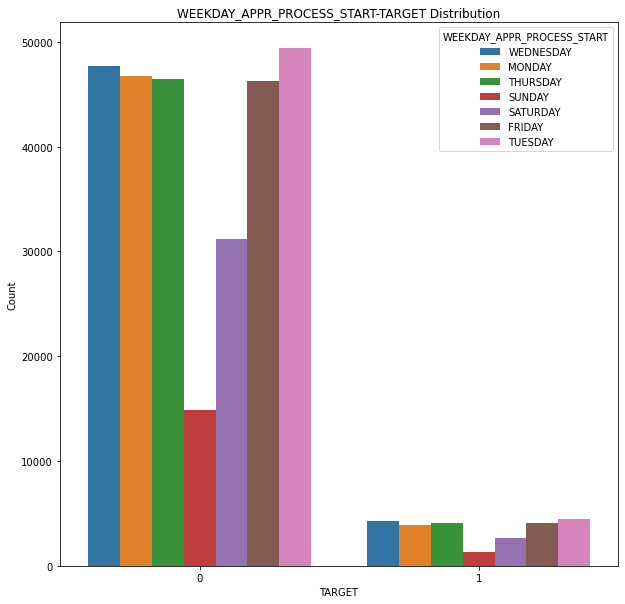

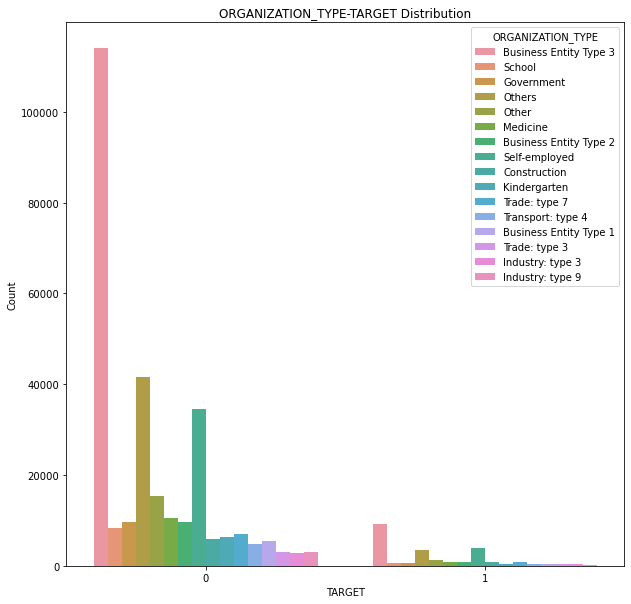

In [80]:
for i in cat_col:
    plt.figure(figsize=(10,10))
    sns.countplot(data = app_train, x = 'TARGET', hue= i)
    plt.xlabel('TARGET')
    plt.ylabel('Count')
    plt.title(f'{i}-TARGET Distribution')
    plt.show()

We observe that  most of the data aren't giving much informaion about the categories, so we need to go for statistical approach to test the dependancy for each variable and the TARGET.

In [81]:
def dependency(data, feature):
    
    table = pd.crosstab(app_train['TARGET'], data[feature])
    stat, p, dof, excpected = chi2_contingency(table) 
    
    print(feature)
    print("Degree of freedom: ", dof)
    significance_level = 0.05
    print("p value: " + str(p)) 

    if p <= significance_level: 
        print( 'REJECT NULL HYPOTHESIS, THE VARIABLES ARE DEPENDENT') 
    else: 
        print('{}: ACCEPT NULL HYPOTHESIS, THE VARIABLES ARE INDEPENDENT')
    print()

In [82]:
for i in cat_col.columns:
    dependency(app_train,i)

NAME_CONTRACT_TYPE
Degree of freedom:  1
p value: 1.0535198778420452e-65
REJECT NULL HYPOTHESIS, THE VARIABLES ARE DEPENDENT

CODE_GENDER
Degree of freedom:  1
p value: 3.60270151906373e-202
REJECT NULL HYPOTHESIS, THE VARIABLES ARE DEPENDENT

FLAG_OWN_CAR
Degree of freedom:  1
p value: 9.815650246750938e-34
REJECT NULL HYPOTHESIS, THE VARIABLES ARE DEPENDENT

FLAG_OWN_REALTY
Degree of freedom:  1
p value: 0.000658182893500346
REJECT NULL HYPOTHESIS, THE VARIABLES ARE DEPENDENT

NAME_TYPE_SUITE
Degree of freedom:  4
p value: 3.483739177497705e-06
REJECT NULL HYPOTHESIS, THE VARIABLES ARE DEPENDENT

NAME_INCOME_TYPE
Degree of freedom:  5
p value: 1.982040677118771e-264
REJECT NULL HYPOTHESIS, THE VARIABLES ARE DEPENDENT

NAME_EDUCATION_TYPE
Degree of freedom:  4
p value: 2.6768578475219473e-219
REJECT NULL HYPOTHESIS, THE VARIABLES ARE DEPENDENT

NAME_FAMILY_STATUS
Degree of freedom:  4
p value: 6.498893361683202e-108
REJECT NULL HYPOTHESIS, THE VARIABLES ARE DEPENDENT

NAME_HOUSING_TYP

### All variables are dependant at 5% significance level

In [83]:
cont_cols_with_target = cont_cols + ['TARGET']


In [84]:
ext_data = app_train[cont_cols_with_target]
ext_data_corrs = ext_data.corr()

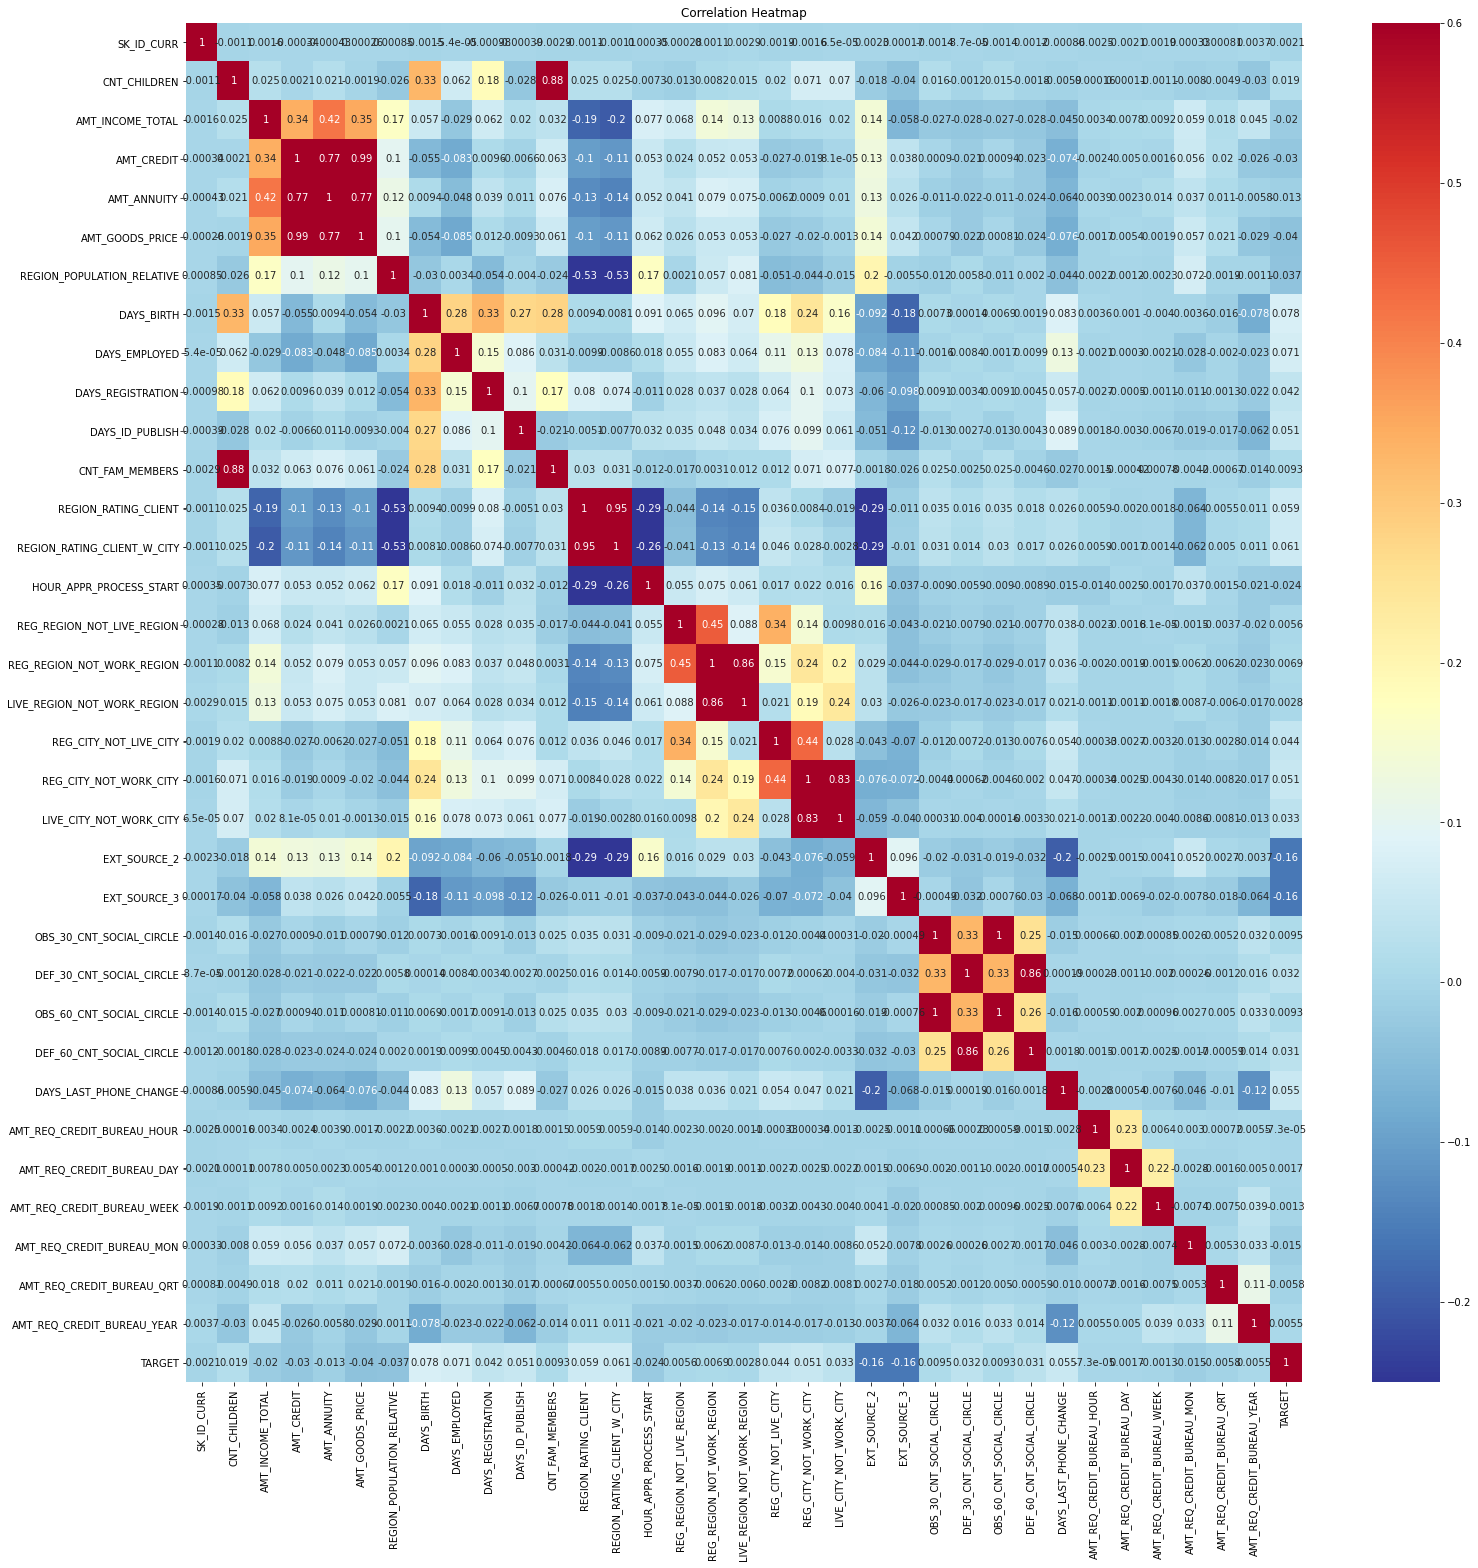

In [85]:
plt.figure(figsize = (25, 25))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

### Findings
* CNT_CHILDREN AND CNT_FAM_MEMBERS have 0.88 correlation
* AMT_CREDIT AND AMT_GOOD_PRICE have 0.99 correlation
* AMT_CREDIT AND AMT_ANNUITY have 0.77 correlation
* REGION_RATING_CLINET AND REGION_RATING_CLIENT_W_CITY have 0.95 correlation
* REG_REGION_NOT_WORK_REGION AND LIVE_REGION_NOT_WORK_REGION have 0.86 correlation
* REG_CITY_NOT_WORK_CITY AND LIVE_CITY_NOT_WORK_CITY have 0.83 correlation
* OBS_30_CNT_SOCIAL_CIRCLE AND OBS_60_CNT_SOCIAL_CIRCLE have 1 correlation
* DEF_30_CNT_SOCIAL_CIRCLE AND DEF_60_CNT_SOCIAL_CIRCLE have 0.86 correlation


In [86]:
ext_data_corrs['TARGET'].abs().sort_values(ascending=False)

TARGET                         1.000000
EXT_SOURCE_2                   0.160284
EXT_SOURCE_3                   0.157300
DAYS_BIRTH                     0.078232
DAYS_EMPLOYED                  0.070921
REGION_RATING_CLIENT_W_CITY    0.060894
REGION_RATING_CLIENT           0.058901
DAYS_LAST_PHONE_CHANGE         0.055206
DAYS_ID_PUBLISH                0.051463
REG_CITY_NOT_WORK_CITY         0.051001
REG_CITY_NOT_LIVE_CITY         0.044399
DAYS_REGISTRATION              0.041981
AMT_GOODS_PRICE                0.039622
REGION_POPULATION_RELATIVE     0.037220
LIVE_CITY_NOT_WORK_CITY        0.032524
DEF_30_CNT_SOCIAL_CIRCLE       0.032398
DEF_60_CNT_SOCIAL_CIRCLE       0.031404
AMT_CREDIT                     0.030369
HOUR_APPR_PROCESS_START        0.024173
AMT_INCOME_TOTAL               0.020460
CNT_CHILDREN                   0.019179
AMT_REQ_CREDIT_BUREAU_MON      0.014791
AMT_ANNUITY                    0.012816
OBS_30_CNT_SOCIAL_CIRCLE       0.009453
OBS_60_CNT_SOCIAL_CIRCLE       0.009344


In [87]:
app_train = app_train.drop(columns=['CNT_FAM_MEMBERS','LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE','log_AMT_INCOME_TOTAL', 'log_AMT_CREDIT', 'YEARS_EMPLOYED'])
app_test = app_test.drop(columns=['CNT_FAM_MEMBERS','LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE'])

In [88]:
cols_to_remove = ['AMT_CREDIT', 'CNT_FAM_MEMBERS', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE','SK_ID_CURR']
cont_cols = list(set(cont_cols) - set(cols_to_remove))
cont_cols 


['AMT_REQ_CREDIT_BUREAU_HOUR',
 'LIVE_CITY_NOT_WORK_CITY',
 'CNT_CHILDREN',
 'EXT_SOURCE_3',
 'REG_CITY_NOT_LIVE_CITY',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'REG_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'AMT_GOODS_PRICE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_ID_PUBLISH',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_POPULATION_RELATIVE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'REGION_RATING_CLIENT',
 'AMT_ANNUITY',
 'HOUR_APPR_PROCESS_START',
 'DAYS_LAST_PHONE_CHANGE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'DAYS_REGISTRATION',
 'EXT_SOURCE_2']

In [89]:
def impute_outliers_IQR(df):

    q1=df.quantile(0.25)
    q3=df.quantile(0.75)

    IQR=q3-q1

    upper = df[~(df>(q3+1.5*IQR))].max()
    lower = df[~(df<(q1-1.5*IQR))].min()

    df = np.where(df > upper, df.quantile(0.8), np.where(df < lower, df.quantile(0.2),df))

    return df

In [90]:
for i in cont_cols:
    app_train[i] = impute_outliers_IQR(app_train[i])
    app_test[i] = impute_outliers_IQR(app_test[i])


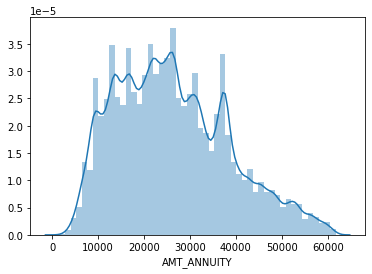

In [91]:
sns.distplot(app_train['AMT_ANNUITY'])


In [92]:
app_train.shape

(307510, 69)

In [93]:
app_test.shape

(48744, 68)

In [95]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307510 entries, 0 to 307510
Data columns (total 69 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307510 non-null  int64  
 1   TARGET                       307510 non-null  int64  
 2   NAME_CONTRACT_TYPE           307510 non-null  object 
 3   CODE_GENDER                  307510 non-null  object 
 4   FLAG_OWN_CAR                 307510 non-null  object 
 5   FLAG_OWN_REALTY              307510 non-null  object 
 6   CNT_CHILDREN                 307510 non-null  float64
 7   AMT_INCOME_TOTAL             307510 non-null  float64
 8   AMT_CREDIT                   307510 non-null  float64
 9   AMT_ANNUITY                  307510 non-null  float64
 10  AMT_GOODS_PRICE              307510 non-null  float64
 11  NAME_TYPE_SUITE              307510 non-null  object 
 12  NAME_INCOME_TYPE             307510 non-null  object 
 13 

### Feature Engineering
There are two indicators which are critical in mortgage approval process.

* LTV, loan to value, ratio = Loan / Value of collateral. Which is 'AMT_CREDIT'/ 'AMT_GOODS_PRICE'.
* DTI, Debt to income, ratio = amount of all the monthly debt payments / the gross monthly income. Which is 'AMT_ANNUITY' / 'AMT_INCOME_TOTAL'
* Employed/Birth, Column represent days employed percentage
* Flag represents if he's greater than 30 or not
* Flag represents if his employmeny years is greater than 5 or not

In [96]:
app_train['LTV'] = app_train['AMT_CREDIT']/app_train['AMT_GOODS_PRICE']
app_train['DTI'] = app_train['AMT_ANNUITY']/app_train['AMT_INCOME_TOTAL']
app_train['Employed/Birth'] = app_train['DAYS_EMPLOYED']/app_train['DAYS_BIRTH'] 
app_train['Flag_Greater_30'] = (app_train['DAYS_BIRTH']/-365.25).apply(lambda x: 1 if x > 30 else 0)
app_train['Flag_Employment_Greater_5'] = (app_train['DAYS_EMPLOYED']/-365.25).apply(lambda x: 1 if x > 5 else 0)

app_test['LTV'] = app_test['AMT_CREDIT']/app_test['AMT_GOODS_PRICE']
app_test['DTI'] = app_test['AMT_ANNUITY']/app_test['AMT_INCOME_TOTAL']
app_test['Employed/Birth'] = app_test['DAYS_EMPLOYED']/app_test['DAYS_BIRTH']
app_test['Flag_Greater_30'] = (app_test['DAYS_BIRTH']/-365.25).apply(lambda x: 1 if x > 30 else 0)
app_test['Flag_Employment_Greater_5'] = (app_test['DAYS_EMPLOYED']/-365.25).apply(lambda x: 1 if x > 5 else 0)

### Model Building

In [101]:
!pip install category_encoders

     -------------------------------------- 81.2/81.2 kB 301.9 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
# for pre-processing

from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# for machine learning modelling
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

First we will convert all the categorical data by OrdinalEncoder into sequence of numbers
Note: I didn't use OneHotEncoding because I'll use RandomForest so it will behave with those numbers as a catgories and split the trees based on them so I don't need OneHotEncoding and avoid sparsity will be good

In [99]:
app_train[cat_col.columns]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Others
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Others
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,Laborers,MONDAY,Business Entity Type 3
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1


#### Target encoding

Target encoding is a technique for encoding categorical variables in machine learning, where the categorical variable is replaced with the mean (or median) of the target variable for each category. It is also known as mean encoding, likelihood encoding, or impact encoding.

In target encoding, each category is replaced with the mean (or median) of the target variable for that category. For example, if the categorical variable is color, and the target variable is price, then the target encoding for the color category "red" would be the mean (or median) price of all the examples that have the color "red". This value is then used as a numerical representation of the "red" category in the model.

Target encoding can be useful for several reasons. First, it can capture the relationship between the categorical variable and the target variable more accurately than one hot encoding or ordinal encoding, especially when there are many categories. Second, it can reduce the dimensionality of the data, as each category is replaced with a single value. However, target encoding can also be prone to overfitting, especially when there are many categories or when the target variable is noisy.

To avoid overfitting, regularization techniques such as smoothing or cross-validation can be used. Smoothing involves adding a prior probability to the target encoding to avoid extreme values, while cross-validation involves using different subsets of the data for encoding and training to avoid leaking information from the target variable.

In [103]:
enc = TargetEncoder()
app_train[cat_col.columns] = enc.fit_transform(app_train[cat_col.columns], app_train['TARGET'])

In [104]:
app_test[cat_col.columns] = enc.transform(app_test[cat_col.columns])

In [105]:
X = app_train.drop(columns=['TARGET','SK_ID_CURR'])
y = app_train['TARGET']

In [106]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [107]:
# create a function for trained models evaluation
def evaluate_model(model):
    # prediction
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_val)
    
    train_pred_proba = model.predict_proba(X_train)
    test_pred_proba = model.predict_proba(X_val)
    
    # evaluations
    print('Training & Validation ROC AUC Scores:\n', '-'*40)
    print('Training   roc auc score= {:.4f}'.format(roc_auc_score(y_train, train_pred_proba[:, 1])))
    print('Validation roc auc score= {:.4f}'.format(roc_auc_score(y_val, test_pred_proba[:, 1])))
    print('')
    print('Training & Validation Confusion Metrices:')
    print('Training   confusion matrix:\n', confusion_matrix(y_train, train_pred))
    print('Validation confusion matrix:\n', confusion_matrix(y_val, test_pred))

### Without class weight or Tuning

In [108]:
rf = RandomForestClassifier(n_estimators=70, max_depth=15, random_state=42)
rf2 = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=5)
rf3 = RandomForestClassifier(n_estimators=75, max_depth=15, random_state=30)
rf4 = RandomForestClassifier(n_estimators=80, max_depth=15, random_state=4)
rf5 = RandomForestClassifier(n_estimators=110, max_depth=15, random_state=12)

In [109]:
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=15, n_estimators=70, random_state=42)

In [110]:
evaluate_model(rf)

Training & Validation ROC AUC Scores:
 ----------------------------------------
Training   roc auc score= 0.9599
Validation roc auc score= 0.7316

Training & Validation Confusion Metrices:
Training   confusion matrix:
 [[226149      0]
 [ 19299    560]]
Validation confusion matrix:
 [[56537     0]
 [ 4964     1]]


In [112]:
rf.fit(X_train, y_train)
rf2.fit(X_train, y_train)
rf3.fit(X_train, y_train)
rf4.fit(X_train, y_train)
rf5.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=110, random_state=12)

In [113]:
y_pred = rf.predict_proba(X_val)
y_pred2 = rf2.predict_proba(X_val)
y_pred3 = rf3.predict_proba(X_val)
y_pred4 = rf4.predict_proba(X_val)
y_pred5 = rf5.predict_proba(X_val)

y_final = (y_pred+y_pred2+y_pred3+y_pred4+y_pred5)/5

In [114]:
roc_auc_score(y_val,y_final[:, 1])

0.7373338327166654

In [115]:
param_grid = {'criterion' : ['gini'],
             'class_weight' : ['balanced_subsample','balanced',None],
             'max_features' : ['sqrt', 'log2'],
             'n_estimators':[70,75,80,100]}

rf2 = RandomForestClassifier( max_depth=15, random_state=42)

grid_cv = RandomizedSearchCV(rf2,param_grid, cv=5,  scoring = 'roc_auc')

grid_cv.fit(X_train, y_train)

y_pred = grid_cv.predict_proba(X_val)

In [116]:
roc_auc_score(y_val, y_pred[:, 1])

0.7325721780891876

In [117]:
# I belive the best_params showed that class weight is better to be None because we used Target Encoding 
grid_cv.best_params_

{'n_estimators': 100,
 'max_features': 'sqrt',
 'criterion': 'gini',
 'class_weight': None}

In [118]:
rf = RandomForestClassifier(max_features= 'sqrt', criterion ='gini', n_estimators=100, max_depth=15, random_state=42)


In [119]:
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=15, random_state=42)

In [120]:
y_final = rf.predict_proba(X_val)


In [121]:
roc_auc_score(y_val, y_final[:, 1])

0.7325721780891876

In [122]:
test_set_dropID = app_test.drop(columns=['SK_ID_CURR'])

y_test_proba = rf.predict_proba(test_set_dropID)


In [123]:
y_test_proba

array([[0.83049432, 0.16950568],
       [0.85073981, 0.14926019],
       [0.92734208, 0.07265792],
       ...,
       [0.87946024, 0.12053976],
       [0.92797861, 0.07202139],
       [0.81965283, 0.18034717]])